In [ ]:
import torch
torch.cuda.is_available()

# Dataset Summary

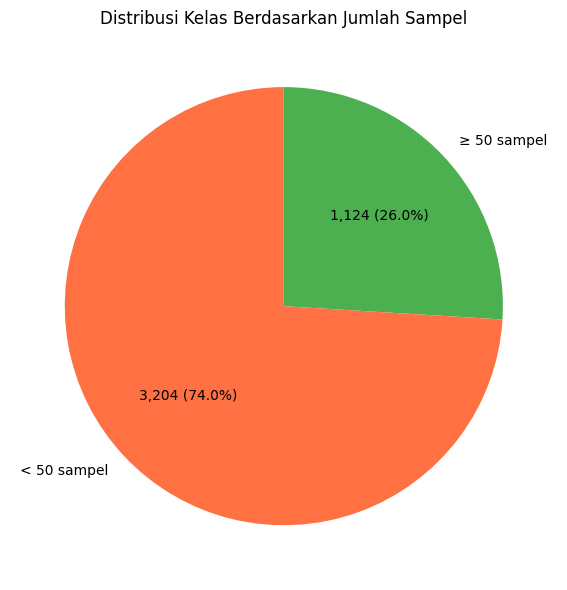

Kelas dengan ≥ 50 sampel: 1124
Kelas dengan < 50 sampel: 3204
Total kelas: 4328


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load your CSV ===
df = pd.read_csv("./yolo_kuzushiji/class_report.csv")

# === Group classes by threshold ===
threshold = 50
above_50 = df[df["Count"] >= threshold]["ClassID"].count()
below_50 = df[df["Count"] < threshold]["ClassID"].count()

# === Prepare chart data ===
labels = [f"≥ {threshold} sampel", f"< {threshold} sampel"]
sizes = [above_50, below_50]
colors = ["#4CAF50", "#FF7043"]

# === Custom label function (show count and percentage) ===
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f"{val:,d} ({pct:.1f}%)"
    return my_autopct

# === Create pie chart ===
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct=make_autopct(sizes),
    startangle=90,
    counterclock=False,
)
plt.title(f"Distribusi Kelas Berdasarkan Jumlah Sampel", fontsize=12)
plt.tight_layout()

# === Save and show the chart ===
plt.savefig("kuzushiji_class_distribution_threshold.png", dpi=300)
plt.show()

# === Print summary in terminal ===
print(f"Kelas dengan ≥ {threshold} sampel: {above_50}")
print(f"Kelas dengan < {threshold} sampel: {below_50}")
print(f"Total kelas: {above_50 + below_50}")

Distribusi dataset kuzushiji

Total character count: 1086287


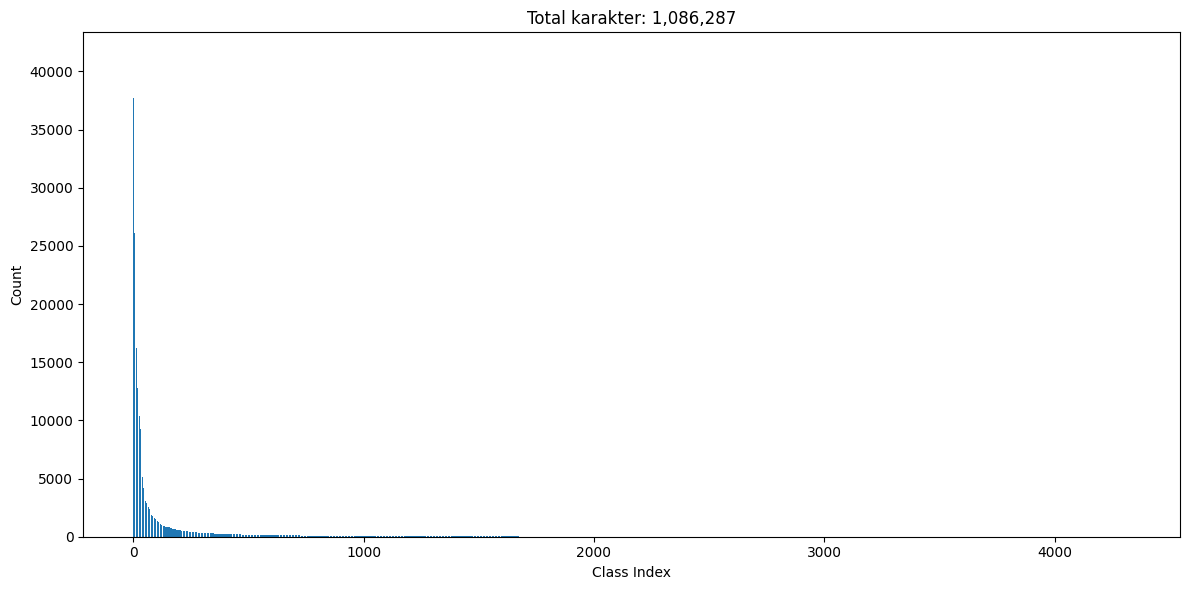

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load CSV ===
df = pd.read_csv("./yolo_kuzushiji/class_report.csv")

# === Compute total and per-class counts ===
total_count = df["Count"].sum()
print(f"Total character count: {total_count}")

# === Plot counts per ClassID ===
plt.figure(figsize=(12, 6))
plt.bar(range(len(df)), df["Count"])
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.title(f"Total karakter: {total_count:,}")
plt.tight_layout()

# === Show the graph ===
plt.savefig("kuzushiji_distribution.png", dpi=300) 
plt.show()

Distribusi dataset kuzushiji cut

Total character count: 251214


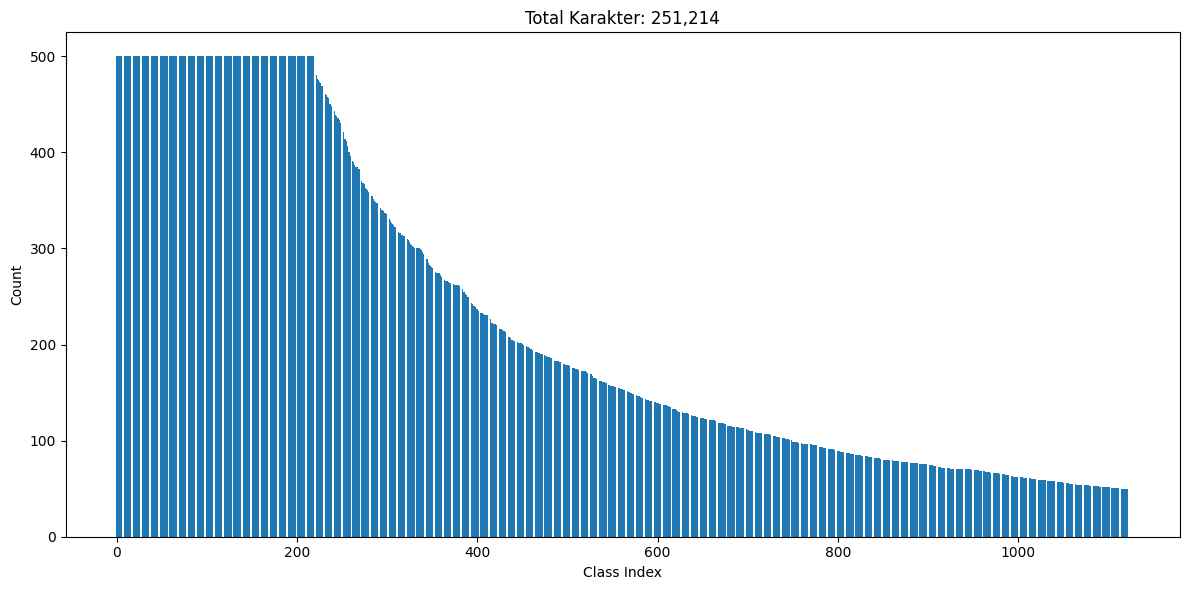

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load CSV ===
df = pd.read_csv("../GAN/class_report.csv")

# === Compute total and per-class counts ===
total_count = df["Count"].sum()
print(f"Total character count: {total_count}")

# === Plot counts per ClassID ===
plt.figure(figsize=(12, 6))
plt.bar(range(len(df)), df["Count"])
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.title(f"Total Karakter: {total_count:,}")
plt.tight_layout()

# === Show the graph ===
plt.savefig("kuzushiji_distribution_cut.png", dpi=300) 
plt.show()

Distribusi dataset kuzushiji cut + GAN

Total character count: 351421


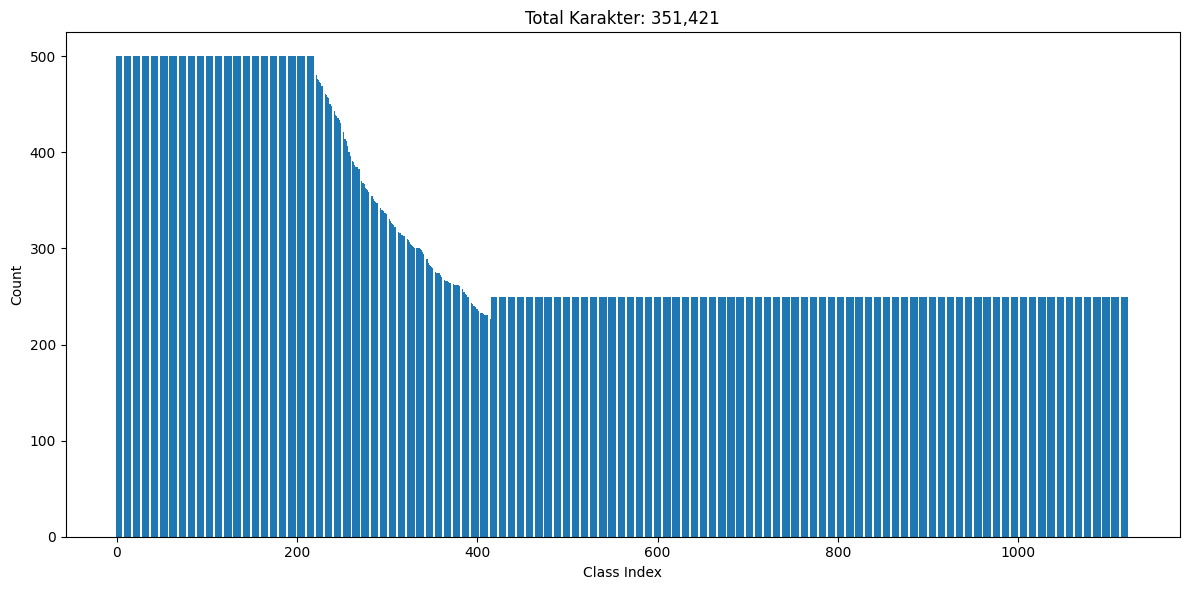

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load CSV ===
df = pd.read_csv("./class_report_after_aug.csv")

# === Compute total and per-class counts ===
total_count = df["Count"].sum()
print(f"Total character count: {int(total_count)}")

# === Plot counts per ClassID ===
plt.figure(figsize=(12, 6))
plt.bar(range(len(df)), df["Count"])
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.title(f"Total Karakter: {int(total_count):,}")
plt.tight_layout()

# === Show the graph ===
plt.savefig("kuzushiji_distribution_cut.png", dpi=300) 
plt.show()

## Data Split

In [ ]:
import os
import random
import shutil
import csv
from collections import Counter

def split_yolo_dataset(dataset_path, output_path, train_ratio=0.8, seed=42):
    random.seed(seed)

    images_path = os.path.join(dataset_path, "images")
    labels_path = os.path.join(dataset_path, "labels")

    # Load all images
    images = [f for f in os.listdir(images_path) if f.lower().endswith((".jpg", ".png", ".jpeg"))]

    # Map: image -> classes inside it
    image_classes = {}
    for img in images:
        lbl_path = os.path.join(labels_path, os.path.splitext(img)[0] + ".txt")
        classes = []
        if os.path.exists(lbl_path):
            with open(lbl_path, "r", encoding="utf-8") as f:
                for line in f:
                    if line.strip():
                        cls = int(line.split()[0])
                        classes.append(cls)
        image_classes[img] = classes

    # Load global class counts from class_report.csv
    class_counts = {}
    csv_path = os.path.join(dataset_path, "class_report.csv")
    with open(csv_path, "r", encoding="utf-8") as cf:
        reader = csv.DictReader(cf)
        for row in reader:
            class_counts[int(row["ClassID"])] = int(row["Count"])

    # Target counts for train/val
    train_targets = {c: int(class_counts[c] * train_ratio) for c in class_counts}
    val_targets = {c: class_counts[c] - train_targets[c] for c in class_counts}

    train_classes = Counter()
    val_classes = Counter()
    train_images, val_images = [], []

    # Shuffle images
    shuffled = list(images)
    random.shuffle(shuffled)

    for img in shuffled:
        cls_list = image_classes[img]
        if not cls_list:  # skip empty
            continue

        # Calculate deficit for train/val
        train_deficit = sum(max(0, train_targets[c] - train_classes[c]) for c in cls_list)
        val_deficit = sum(max(0, val_targets[c] - val_classes[c]) for c in cls_list)

        # Assign to the split that needs it more
        if train_deficit >= val_deficit:
            train_images.append(img)
            train_classes.update(cls_list)
        else:
            val_images.append(img)
            val_classes.update(cls_list)

    # Helper to copy
    def copy_files(image_list, subset):
        subset_img_path = os.path.join(output_path, subset, "images")
        subset_lbl_path = os.path.join(output_path, subset, "labels")
        os.makedirs(subset_img_path, exist_ok=True)
        os.makedirs(subset_lbl_path, exist_ok=True)

        obj_counter = Counter()
        for i, img in enumerate(image_list, 1):
            img_src = os.path.join(images_path, img)
            lbl_src = os.path.join(labels_path, os.path.splitext(img)[0] + ".txt")

            img_dst = os.path.join(subset_img_path, img)
            lbl_dst = os.path.join(subset_lbl_path, os.path.splitext(img)[0] + ".txt")

            shutil.copy(img_src, img_dst)
            if os.path.exists(lbl_src):
                with open(lbl_src, "r", encoding="utf-8") as lf:
                    for line in lf:
                        if line.strip():
                            obj_counter[int(line.split()[0])] += 1
                shutil.copy(lbl_src, lbl_dst)

            print(f"\r[{subset.upper()}] Copied {i}/{len(image_list)} images", end="", flush=True)

        print(f"\n✅ {subset.upper()} split: {len(image_list)} images")
        return obj_counter

    print(f"Splitting {len(images)} images into {int(train_ratio*100)}% train / {100-int(train_ratio*100)}% val...")

    train_stats = copy_files(train_images, "train")
    val_stats = copy_files(val_images, "validation")

    print("\n=== Split Summary ===")
    print(f"Train: {len(train_images)} images | class counts: {dict(train_stats)}")
    print(f"Val  : {len(val_images)} images | class counts: {dict(val_stats)}")
    print(f"Total: {len(train_images) + len(val_images)} images")

# Example usage
dataset_path = "yolo_kuzushiji_cut"
output_path = "yolo_kuzushiji_cut_split"
split_yolo_dataset(dataset_path, output_path, train_ratio=0.8)

YOLO YAML Formatter

In [ ]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': './yolo_kuzushiji_cut_split',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = 'yolo_kuzushiji_cut_split/classes.txt'
path_to_data_yaml = 'yolo_kuzushiji_cut_split/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
with open(path_to_data_yaml, 'r', encoding='utf-8') as f:
    print(f.read())

# YOLO V11

## Yolo Train

In [1]:
from ultralytics import YOLO

model = YOLO("yolo11m.pt")
# YOLO V11 w/o GAN Augmentation 

# Train
model.train(
    seed=420,
    data="yolo_kuzushiji_cut_split_gan_augment/data.yaml",  # dataset yaml
    epochs=100,
    imgsz=960,
    batch=4,
    name="kuzushiji_GAN_tuned",
    translate=0.05,
    scale=0.15,
    degrees=7,
    optimizer='SGD',
    # fliplr=0.5,   
    mosaic=0.2,
    hsv_v=0.5,
    erasing=0.2,
    cache=False,
    cos_lr=True,            # cosine learning rate schedule
    patience=50 
)

# model.train(
#     data="yolo_kuzushiji_cut_split/data.yaml",  # dataset yaml
#     epochs=100,
#     imgsz=960,
#     batch=4,
#     name="kuzushiji_noGAN",
#     translate=0.1,
#     scale=0.15,
#     degrees=10,
#     # fliplr=0.5,   
#     # mosaic=0.0,
#     hsv_v=0.5,
#     erasing=0.2,
#     cache=False,
#     cos_lr=True,
# )

New https://pypi.org/project/ultralytics/8.3.221 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.160  Python-3.13.0 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=yolo_kuzushiji_cut_split_gan_augment/data.yaml, degrees=7, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.2, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.5, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=0.2, multi_scale=False, name=kuzushi

train: Scanning C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split_gan_augment\train\labels... 5782 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5782/5782 [00:06<00:00, 873.80it/s] 


train: New cache created: C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split_gan_augment\train\labels.cache
val: Fast image access  (ping: 0.20.0 ms, read: 42.27.7 MB/s, size: 669.0 KB)


val: Scanning C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split_gan_augment\validation\labels... 1096 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1096/1096 [00:03<00:00, 294.64it/s]


val: New cache created: C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split_gan_augment\validation\labels.cache
Plotting labels to runs\detect\kuzushiji_GAN_tuned\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 960 train, 960 val
Using 8 dataloader workers
Logging results to runs\detect\kuzushiji_GAN_tuned
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.38G      0.773      4.956     0.8888         45        960: 100%|██████████| 1446/1446 [14:27<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:14<00:00,  1.83it/s]


                   all       1096      50276      0.494     0.0798     0.0602     0.0484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.38G     0.6964      2.844     0.8547         65        960: 100%|██████████| 1446/1446 [17:16<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:06<00:00,  2.06it/s]


                   all       1096      50276      0.415        0.3       0.29      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.43G     0.7282      1.932     0.8632         85        960: 100%|██████████| 1446/1446 [16:47<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:03<00:00,  2.17it/s]


                   all       1096      50276      0.532      0.438      0.469      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.38G     0.6935      1.478     0.8567         47        960: 100%|██████████| 1446/1446 [16:45<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:22<00:00,  1.67it/s]


                   all       1096      50276      0.643       0.55      0.614      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       7.4G     0.6346      1.188     0.8437        135        960: 100%|██████████| 1446/1446 [16:38<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:49<00:00,  1.25it/s]


                   all       1096      50276      0.706      0.602      0.682      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       7.4G     0.5916      1.018     0.8343         85        960: 100%|██████████| 1446/1446 [16:25<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:26<00:00,  1.59it/s]


                   all       1096      50276      0.683      0.579      0.661      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.45G     0.5615     0.9234     0.8292        146        960: 100%|██████████| 1446/1446 [16:29<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.57it/s]


                   all       1096      50276      0.769      0.682      0.769      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.52G     0.5358     0.8371     0.8236        132        960: 100%|██████████| 1446/1446 [16:23<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:52<00:00,  2.60it/s]


                   all       1096      50276      0.777      0.696      0.786      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.45G     0.5224     0.7839     0.8209        114        960: 100%|██████████| 1446/1446 [16:25<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.56it/s]


                   all       1096      50276      0.792      0.711      0.797      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       7.4G     0.5054     0.7239      0.818        104        960: 100%|██████████| 1446/1446 [16:21<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:52<00:00,  2.59it/s]


                   all       1096      50276      0.821      0.737       0.83      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.36G     0.4894     0.6891     0.8148         86        960: 100%|██████████| 1446/1446 [16:15<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:54<00:00,  2.50it/s]


                   all       1096      50276      0.817      0.753      0.838      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.42G     0.4829     0.6472     0.8133        102        960: 100%|██████████| 1446/1446 [16:07<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:05<00:00,  2.08it/s]


                   all       1096      50276       0.83      0.755      0.845      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.46G     0.4683     0.6185     0.8105        136        960: 100%|██████████| 1446/1446 [16:34<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:16<00:00,  1.79it/s]


                   all       1096      50276      0.831      0.763      0.852      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.45G     0.4583     0.6083     0.8094         94        960: 100%|██████████| 1446/1446 [16:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:54<00:00,  2.51it/s]


                   all       1096      50276      0.847       0.78      0.867      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.35G     0.4553     0.5703     0.8078         32        960: 100%|██████████| 1446/1446 [16:24<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:54<00:00,  2.50it/s]


                   all       1096      50276      0.851      0.785      0.872       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.49G     0.4444     0.5589     0.8072        151        960: 100%|██████████| 1446/1446 [16:48<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:52<00:00,  2.61it/s]


                   all       1096      50276      0.864      0.801      0.883      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.48G     0.4384      0.536      0.805         62        960: 100%|██████████| 1446/1446 [16:49<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:57<00:00,  2.37it/s]


                   all       1096      50276      0.859      0.802      0.883      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.38G     0.4316      0.525     0.8043         59        960: 100%|██████████| 1446/1446 [17:55<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:59<00:00,  2.31it/s]


                   all       1096      50276      0.849      0.795      0.875      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.52G     0.4287     0.5141     0.8037         72        960: 100%|██████████| 1446/1446 [17:40<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:57<00:00,  2.38it/s]


                   all       1096      50276      0.872      0.811      0.891      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       7.4G     0.4198     0.4985     0.8015        155        960: 100%|██████████| 1446/1446 [17:51<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:55<00:00,  2.46it/s]


                   all       1096      50276      0.868      0.819      0.895        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.55G      0.415     0.4817     0.8011         40        960: 100%|██████████| 1446/1446 [17:48<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:15<00:00,  1.82it/s]


                   all       1096      50276      0.873       0.82      0.898      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.32G     0.4206      0.479     0.8021        248        960:  16%|█▌        | 234/1446 [02:51<14:47,  1.37it/s]


KeyboardInterrupt: 

Resume training if interrupted

In [1]:
from ultralytics import YOLO

model = YOLO('./runs/detect/kuzushiji_GAN_tuned/weights/last.pt')
# Train
model.train(
    seed=420,
    data="yolo_kuzushiji_cut_split_gan_augment/data.yaml",  # dataset yaml
    epochs=100,
    imgsz=960,
    batch=4,
    name="kuzushiji_GAN_tuned",
    translate=0.05,
    scale=0.15,
    degrees=7,
    optimizer='SGD',
    # fliplr=0.5,   
    mosaic=0.2,
    hsv_v=0.5,
    erasing=0.2,
    cache=False,
    cos_lr=True,            # cosine learning rate schedule
    patience=50, 
    resume=True
)
# # resume train the model
# model.train(
#     data="yolo_kuzushiji_cut_split/data.yaml",  # dataset yaml
#     epochs=100,
#     imgsz=640,
#     batch=8,
#     name="kuzushiji",
#     translate=0.1,
#     scale=0.3,
#     degrees=30,
#     # fliplr=0.5,   
#     # mosaic=0.0,
#     hsv_v=0.5,
#     erasing=0.2,
#     resume=True
# )

New https://pypi.org/project/ultralytics/8.3.221 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.160  Python-3.13.0 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=yolo_kuzushiji_cut_split_gan_augment/data.yaml, degrees=7, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.2, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.5, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs\detect\kuzushiji_GAN_tuned\weights\last.pt, momentum=0.937, mosaic

train: Scanning C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split_gan_augment\train\labels.cache... 5782 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5782/5782 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.1 ms, read: 230.752.5 MB/s, size: 669.0 KB)


val: Scanning C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split_gan_augment\validation\labels.cache... 1096 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1096/1096 [00:00<?, ?it/s]


Plotting labels to runs\detect\kuzushiji_GAN_tuned\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Resuming training runs\detect\kuzushiji_GAN_tuned\weights\last.pt from epoch 22 to 100 total epochs
Image sizes 960 train, 960 val
Using 8 dataloader workers
Logging results to runs\detect\kuzushiji_GAN_tuned
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.44G     0.4118     0.4702      0.801         45        960: 100%|██████████| 1446/1446 [14:42<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:54<00:00,  2.51it/s]


                   all       1096      50276      0.878      0.821        0.9      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.36G     0.4072     0.4668     0.7996         65        960: 100%|██████████| 1446/1446 [16:00<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:55<00:00,  2.48it/s]


                   all       1096      50276      0.877      0.826      0.902      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.43G     0.4038     0.4554     0.7991         85        960: 100%|██████████| 1446/1446 [16:14<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:56<00:00,  2.43it/s]


                   all       1096      50276      0.875      0.827      0.904      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.43G        0.4     0.4419     0.7989         47        960: 100%|██████████| 1446/1446 [16:49<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.14it/s]


                   all       1096      50276      0.887      0.841      0.912      0.814

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.41G     0.3966     0.4361     0.7979        135        960: 100%|██████████| 1446/1446 [17:58<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:58<00:00,  2.35it/s]


                   all       1096      50276      0.886      0.841      0.912      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.44G     0.3893     0.4262     0.7966         85        960: 100%|██████████| 1446/1446 [16:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:59<00:00,  2.31it/s]


                   all       1096      50276      0.893      0.844      0.915      0.821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.46G     0.3887     0.4136     0.7965        146        960: 100%|██████████| 1446/1446 [17:27<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:55<00:00,  2.49it/s]


                   all       1096      50276      0.896      0.846      0.917      0.817

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.42G     0.3845     0.4077     0.7953        132        960: 100%|██████████| 1446/1446 [16:39<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:56<00:00,  2.44it/s]


                   all       1096      50276      0.893      0.845      0.917       0.82

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.45G     0.3862      0.402     0.7956        114        960: 100%|██████████| 1446/1446 [16:21<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.56it/s]


                   all       1096      50276      0.894      0.843      0.917      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.46G     0.3781     0.3936     0.7944        104        960: 100%|██████████| 1446/1446 [16:32<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:54<00:00,  2.52it/s]


                   all       1096      50276      0.891      0.854      0.919      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.35G     0.3776     0.3825     0.7938         86        960: 100%|██████████| 1446/1446 [16:34<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:56<00:00,  2.42it/s]


                   all       1096      50276      0.908      0.856      0.926      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       7.5G     0.3712     0.3762     0.7933        102        960: 100%|██████████| 1446/1446 [16:55<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:58<00:00,  2.35it/s]


                   all       1096      50276      0.881      0.849      0.909      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.47G     0.3683      0.368     0.7923        136        960: 100%|██████████| 1446/1446 [16:48<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:50<00:00,  2.72it/s]


                   all       1096      50276      0.897      0.862      0.925      0.832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.45G     0.3667     0.3675      0.792         94        960: 100%|██████████| 1446/1446 [15:42<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:50<00:00,  2.69it/s]


                   all       1096      50276      0.905      0.862      0.927      0.838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.36G     0.3646     0.3569     0.7914         32        960: 100%|██████████| 1446/1446 [15:13<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:52<00:00,  2.62it/s]


                   all       1096      50276      0.906      0.863      0.928      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.46G     0.3642     0.3534      0.792        151        960: 100%|██████████| 1446/1446 [16:15<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.54it/s]


                   all       1096      50276      0.902      0.865      0.927      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.46G     0.3599     0.3473     0.7906         62        960: 100%|██████████| 1446/1446 [15:59<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.54it/s]


                   all       1096      50276      0.903      0.865      0.928      0.839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.38G     0.3589     0.3406     0.7908         59        960: 100%|██████████| 1446/1446 [16:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:54<00:00,  2.53it/s]


                   all       1096      50276      0.905      0.869      0.931      0.842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.52G     0.3558     0.3387     0.7902         72        960: 100%|██████████| 1446/1446 [16:14<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:54<00:00,  2.53it/s]


                   all       1096      50276      0.905      0.872      0.932      0.846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.39G     0.3508     0.3325     0.7887        155        960: 100%|██████████| 1446/1446 [15:59<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.58it/s]


                   all       1096      50276      0.917      0.868      0.933      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.51G      0.349     0.3255     0.7888         40        960: 100%|██████████| 1446/1446 [16:35<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:52<00:00,  1.22it/s]


                   all       1096      50276      0.912      0.869      0.933      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.35G     0.3509     0.3347     0.7898        137        960: 100%|██████████| 1446/1446 [30:05<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:46<00:00,  2.92it/s]


                   all       1096      50276      0.913      0.875      0.935      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.41G     0.3468     0.3293     0.7887        132        960: 100%|██████████| 1446/1446 [16:00<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:54<00:00,  2.52it/s]


                   all       1096      50276      0.916      0.871      0.933       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.52G     0.3447     0.3211     0.7881         43        960: 100%|██████████| 1446/1446 [16:12<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:51<00:00,  2.66it/s]


                   all       1096      50276      0.913      0.878      0.936      0.848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.41G      0.344     0.3228     0.7882         94        960: 100%|██████████| 1446/1446 [16:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:51<00:00,  2.68it/s]


                   all       1096      50276      0.916      0.877      0.937      0.852

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.43G     0.3419     0.3102     0.7878         39        960: 100%|██████████| 1446/1446 [16:12<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:54<00:00,  2.49it/s]


                   all       1096      50276      0.915      0.879      0.937       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       7.5G     0.3397      0.306     0.7872        216        960: 100%|██████████| 1446/1446 [16:29<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.54it/s]


                   all       1096      50276      0.924      0.879       0.94      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.43G     0.3384     0.3073     0.7869         93        960: 100%|██████████| 1446/1446 [16:12<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.57it/s]


                   all       1096      50276       0.92      0.877      0.938      0.851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       7.4G     0.3327     0.2994     0.7857        146        960: 100%|██████████| 1446/1446 [16:01<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.57it/s]


                   all       1096      50276       0.92       0.88      0.938      0.851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.39G     0.3331     0.2981     0.7862         66        960: 100%|██████████| 1446/1446 [16:12<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.56it/s]


                   all       1096      50276      0.925      0.875      0.939      0.855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.44G     0.3309     0.2948     0.7855        194        960: 100%|██████████| 1446/1446 [16:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:52<00:00,  2.63it/s]


                   all       1096      50276      0.921      0.884       0.94      0.857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.41G     0.3284     0.2927     0.7851        100        960: 100%|██████████| 1446/1446 [15:54<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.56it/s]


                   all       1096      50276      0.919      0.886      0.941      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.28G      0.327     0.2842     0.7852        160        960: 100%|██████████| 1446/1446 [15:43<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:13<00:00,  1.86it/s]


                   all       1096      50276      0.925      0.882      0.941      0.857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.43G     0.3257     0.2833      0.785        116        960: 100%|██████████| 1446/1446 [15:28<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.56it/s]


                   all       1096      50276      0.922      0.888      0.942      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.39G     0.3218     0.2822     0.7837         49        960: 100%|██████████| 1446/1446 [15:37<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:49<00:00,  2.75it/s]


                   all       1096      50276      0.921      0.889      0.943      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.45G     0.3213     0.2781     0.7838        118        960: 100%|██████████| 1446/1446 [16:07<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:51<00:00,  2.68it/s]


                   all       1096      50276      0.923      0.886      0.943      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.43G     0.3185     0.2716     0.7831        168        960: 100%|██████████| 1446/1446 [16:17<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:52<00:00,  2.60it/s]


                   all       1096      50276      0.925      0.886      0.944      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.44G     0.3179     0.2702     0.7828        127        960: 100%|██████████| 1446/1446 [15:34<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:50<00:00,  2.71it/s]


                   all       1096      50276      0.923      0.884      0.942      0.855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.47G     0.3155     0.2666      0.783        163        960: 100%|██████████| 1446/1446 [15:53<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:07<00:00,  2.04it/s]


                   all       1096      50276      0.926      0.888      0.943      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       7.4G     0.3139     0.2628     0.7827        118        960: 100%|██████████| 1446/1446 [16:04<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:58<00:00,  2.34it/s]


                   all       1096      50276      0.921       0.89      0.943       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.41G     0.3115     0.2603     0.7824        119        960: 100%|██████████| 1446/1446 [16:48<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:50<00:00,  1.24it/s]


                   all       1096      50276       0.92      0.893      0.944      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.43G     0.3084     0.2559     0.7815         83        960: 100%|██████████| 1446/1446 [20:13<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:00<00:00,  2.27it/s]


                   all       1096      50276      0.928       0.89      0.945      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       7.4G     0.3083     0.2545     0.7812         85        960: 100%|██████████| 1446/1446 [16:32<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:52<00:00,  2.59it/s]


                   all       1096      50276       0.93      0.892      0.945      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.41G     0.3081     0.2535     0.7812         88        960: 100%|██████████| 1446/1446 [16:30<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:52<00:00,  2.61it/s]


                   all       1096      50276      0.926      0.893      0.945      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.43G     0.3042     0.2488     0.7806        106        960: 100%|██████████| 1446/1446 [16:59<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:56<00:00,  2.41it/s]


                   all       1096      50276      0.921      0.893      0.943       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.38G     0.3035     0.2472     0.7803         91        960: 100%|██████████| 1446/1446 [16:36<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:51<00:00,  2.64it/s]


                   all       1096      50276      0.931      0.886      0.945      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.38G     0.3033      0.245     0.7801        107        960: 100%|██████████| 1446/1446 [17:05<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:52<00:00,  2.62it/s]


                   all       1096      50276      0.929       0.89      0.945      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.41G     0.2996     0.2415     0.7798        129        960: 100%|██████████| 1446/1446 [16:59<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:52<00:00,  2.62it/s]


                   all       1096      50276      0.927      0.893      0.946      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.39G     0.2988     0.2395     0.7796        106        960: 100%|██████████| 1446/1446 [17:25<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:55<00:00,  2.49it/s]


                   all       1096      50276       0.93      0.892      0.946      0.866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.49G     0.2961     0.2379     0.7793         62        960: 100%|██████████| 1446/1446 [16:53<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:59<00:00,  2.32it/s]


                   all       1096      50276      0.928      0.893      0.946      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.37G     0.2955     0.2351     0.7792        109        960: 100%|██████████| 1446/1446 [17:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:58<00:00,  2.33it/s]


                   all       1096      50276      0.925      0.894      0.946      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       7.5G     0.2963     0.2344     0.7791         75        960: 100%|██████████| 1446/1446 [16:46<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:59<00:00,  2.31it/s]


                   all       1096      50276      0.934      0.888      0.946      0.866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.43G      0.293     0.2309     0.7793        114        960: 100%|██████████| 1446/1446 [16:25<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:52<00:00,  2.62it/s]


                   all       1096      50276      0.931       0.89      0.946      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.44G     0.2909     0.2281     0.7779        107        960: 100%|██████████| 1446/1446 [16:31<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.54it/s]


                   all       1096      50276      0.926      0.895      0.946      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.37G     0.2902     0.2267     0.7784         97        960: 100%|██████████| 1446/1446 [16:25<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:26<00:00,  1.57it/s]


                   all       1096      50276       0.93      0.892      0.946      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.41G     0.2891     0.2244     0.7777         81        960: 100%|██████████| 1446/1446 [16:24<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.55it/s]


                   all       1096      50276      0.928      0.894      0.947      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.33G     0.2875     0.2232     0.7776         81        960: 100%|██████████| 1446/1446 [16:23<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:51<00:00,  2.65it/s]


                   all       1096      50276      0.929      0.896      0.947      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       7.4G     0.2859     0.2209     0.7773         79        960: 100%|██████████| 1446/1446 [16:01<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.54it/s]


                   all       1096      50276      0.932      0.894      0.947      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.51G     0.2844     0.2187     0.7777        152        960: 100%|██████████| 1446/1446 [15:51<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:53<00:00,  2.54it/s]


                   all       1096      50276       0.93      0.894      0.948      0.866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.46G     0.2843     0.2169     0.7768         30        960: 100%|██████████| 1446/1446 [16:23<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:55<00:00,  2.46it/s]


                   all       1096      50276      0.932      0.894      0.947      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       7.4G     0.2829     0.2155     0.7766        127        960: 100%|██████████| 1446/1446 [16:19<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:52<00:00,  2.59it/s]


                   all       1096      50276      0.933      0.892      0.947      0.866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.43G     0.2831     0.2144      0.777         51        960: 100%|██████████| 1446/1446 [15:39<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:50<00:00,  2.71it/s]


                   all       1096      50276      0.929      0.895      0.947      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.41G     0.2803     0.2131     0.7767        135        960: 100%|██████████| 1446/1446 [15:54<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:50<00:00,  2.72it/s]


                   all       1096      50276      0.934      0.891      0.947      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.39G     0.2813     0.2122     0.7762        110        960: 100%|██████████| 1446/1446 [15:18<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:39<00:00,  1.37it/s]


                   all       1096      50276      0.934      0.892      0.947      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       7.4G     0.2775      0.209     0.7759        202        960: 100%|██████████| 1446/1446 [15:06<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:50<00:00,  2.73it/s]


                   all       1096      50276      0.935       0.89      0.947      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.43G     0.2769     0.2079     0.7755         65        960: 100%|██████████| 1446/1446 [14:58<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:50<00:00,  2.69it/s]


                   all       1096      50276      0.932      0.894      0.947      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.52G     0.2772     0.2067     0.7757        155        960: 100%|██████████| 1446/1446 [14:58<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:52<00:00,  2.63it/s]


                   all       1096      50276      0.933      0.893      0.947      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.44G     0.2769      0.207     0.7758         39        960: 100%|██████████| 1446/1446 [15:07<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:51<00:00,  2.66it/s]


                   all       1096      50276      0.934      0.891      0.947      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.41G     0.2767      0.207     0.7757         92        960: 100%|██████████| 1446/1446 [15:05<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:48<00:00,  2.84it/s]


                   all       1096      50276      0.936       0.89      0.947      0.868
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.49G      0.269     0.1873      0.773         69        960: 100%|██████████| 1446/1446 [15:19<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:54<00:00,  2.52it/s]


                   all       1096      50276      0.936       0.89      0.947      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.39G     0.2692     0.1869     0.7727         46        960: 100%|██████████| 1446/1446 [15:26<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:50<00:00,  2.72it/s]


                   all       1096      50276      0.936       0.89      0.947      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.43G     0.2684     0.1859     0.7733        123        960: 100%|██████████| 1446/1446 [15:41<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:50<00:00,  2.73it/s]


                   all       1096      50276      0.934      0.892      0.947      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.42G     0.2682     0.1853     0.7728        138        960: 100%|██████████| 1446/1446 [15:53<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:51<00:00,  2.64it/s]


                   all       1096      50276      0.935      0.891      0.947      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.43G     0.2669     0.1842     0.7722        142        960: 100%|██████████| 1446/1446 [15:41<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:50<00:00,  2.70it/s]


                   all       1096      50276      0.936      0.891      0.947      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.42G     0.2668     0.1836     0.7724        144        960: 100%|██████████| 1446/1446 [15:48<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:49<00:00,  2.78it/s]


                   all       1096      50276      0.935      0.892      0.947      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.48G     0.2674     0.1834     0.7727        100        960: 100%|██████████| 1446/1446 [15:45<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:51<00:00,  2.64it/s]


                   all       1096      50276      0.936       0.89      0.947      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.42G     0.2666     0.1825     0.7723         90        960: 100%|██████████| 1446/1446 [16:32<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:52<00:00,  2.59it/s]


                   all       1096      50276      0.937      0.889      0.947      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.48G     0.2659     0.1823     0.7722        118        960: 100%|██████████| 1446/1446 [16:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:54<00:00,  2.50it/s]


                   all       1096      50276      0.936      0.889      0.947      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.38G     0.2667     0.1832     0.7726         91        960: 100%|██████████| 1446/1446 [16:30<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:55<00:00,  2.49it/s]


                   all       1096      50276      0.934      0.891      0.947      0.868

79 epochs completed in 22.938 hours.
Optimizer stripped from runs\detect\kuzushiji_GAN_tuned\weights\last.pt, 42.3MB
Optimizer stripped from runs\detect\kuzushiji_GAN_tuned\weights\best.pt, 42.3MB

Validating runs\detect\kuzushiji_GAN_tuned\weights\best.pt...
Ultralytics 8.3.160  Python-3.13.0 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 8192MiB)
YOLO11m summary (fused): 125 layers, 20,896,636 parameters, 0 gradients, 72.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:37<00:00,  3.69it/s]


                   all       1096      50276      0.932      0.894      0.947      0.869
                U+306E         17        100      0.856       0.87      0.865      0.788
                U+306B         18         93      0.769      0.914      0.918      0.788
                U+3057         19         94      0.654      0.819      0.803      0.562
                U+3066         24        105      0.917      0.948      0.967      0.842
                U+3068         38         96      0.835      0.938      0.929      0.789
                U+304B         40        103      0.856      0.932      0.906      0.668
                U+306F         38        104      0.894      0.981      0.964      0.802
                U+3092         22        100      0.903          1      0.966      0.882
                U+308A         21        106      0.739      0.934      0.843      0.705
                U+306A         32         98        0.9      0.939      0.947      0.813
                U+308

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([   0,    1,    2, ..., 1121, 1122, 1123])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002079FA2D080>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0

## Evaluate Model

### Per class result of each metric

In [2]:
from ultralytics import YOLO

model = YOLO("prev_runs/01_11_V10-500capGAN960imgsz100epochs/weights/best.pt")

metrics = model.val(
    data="yolo_kuzushiji_cut_split/data.yaml",
    verbose=True
)

# Convert to CSV string
csv_str = metrics.to_csv()

# Save to file
with open("prev_runs/01_11_V10-500capGAN960imgsz100epochs/per_class_results.csv", "w") as f:
    f.write(csv_str)

Ultralytics 8.3.160  Python-3.13.0 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 8192MiB)
YOLOv10m summary (fused): 136 layers, 15,963,964 parameters, 0 gradients, 62.5 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 1127.9137.9 MB/s, size: 750.1 KB)


val: Scanning C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split\validation\labels.cache... 1096 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1096/1096 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [07:39<00:00,  6.66s/it]


                   all       1096      50276      0.906      0.862      0.925      0.856
                U+306E         17        100      0.923      0.844      0.932      0.849
                U+306B         18         93       0.75       0.87      0.883      0.759
                U+3057         19         94      0.782      0.777      0.831       0.59
                U+3066         24        105      0.904      0.901      0.925      0.805
                U+3068         38         96      0.966      0.889      0.947      0.818
                U+304B         40        103      0.897      0.845      0.927      0.713
                U+306F         38        104       0.98      0.945      0.973      0.823
                U+3092         22        100      0.884       0.98      0.942      0.855
                U+308A         21        106      0.798      0.962       0.87       0.74
                U+306A         32         98      0.914      0.878      0.942      0.838
                U+308

### Rata - rata persentase perubahan pada kelas yang teraugmentasi

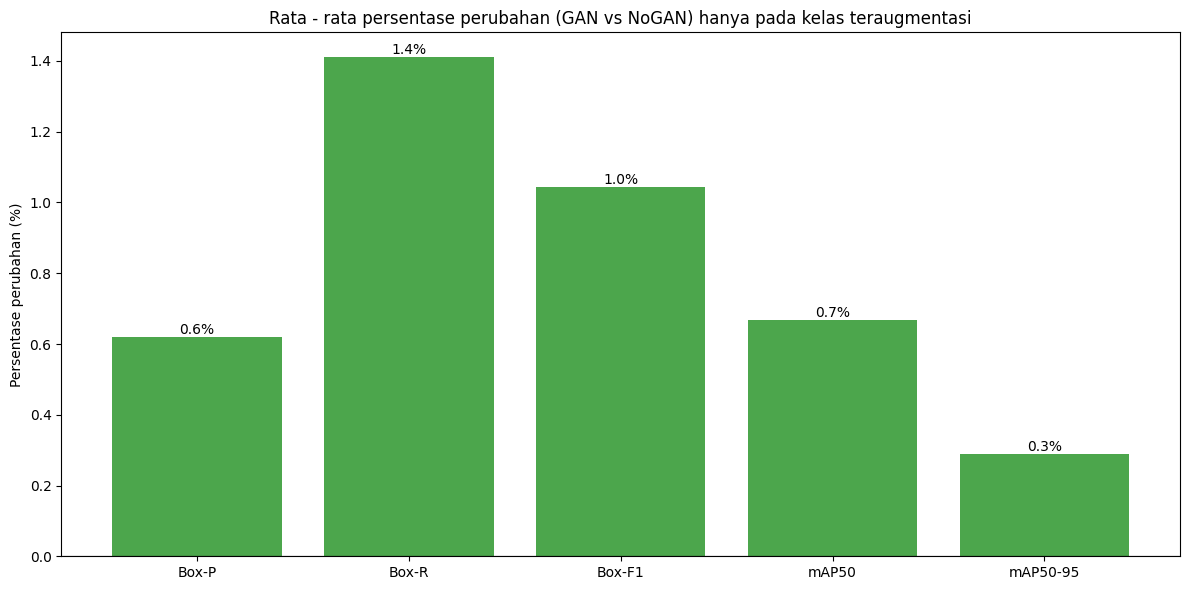

C:\Users\aktsa_wi2suow\AppData\Local\Temp\ipykernel_13224\2067393384.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f"{metric}_Delta%"] = ((df_filtered[f"{metric}_GAN"] - df_filtered[f"{metric}_NoGAN"]) / df_filtered[f"{metric}_NoGAN"]) * 100
C:\Users\aktsa_wi2suow\AppData\Local\Temp\ipykernel_13224\2067393384.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f"{metric}_Delta%"] = ((df_filtered[f"{metric}_GAN"] - df_filtered[f"{metric}_NoGAN"]) / df_filtered[f"{metric}_NoGAN

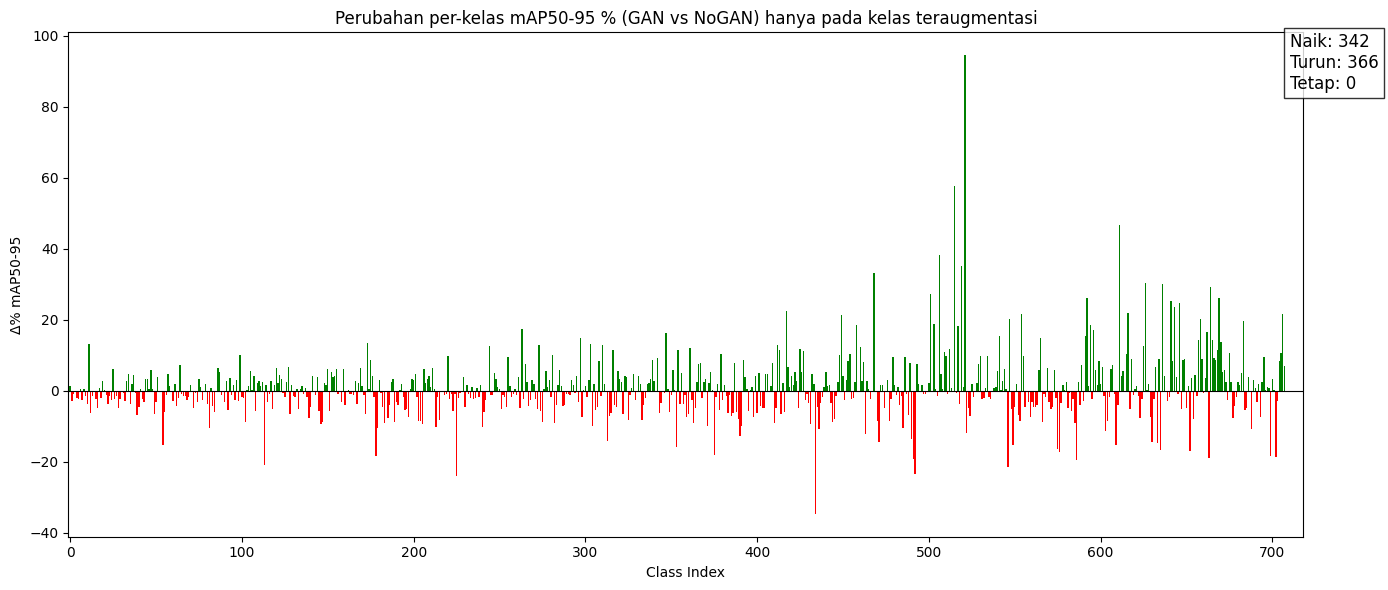


🔼 Top 10 Classes Improved by GAN (mAP50-95 %):
       Class  mAP50-95_Delta%
937   U+53E5        94.454713
931   U+73CD        57.672735
1027  U+89A7        46.743737
922   U+8A63        38.136652
935   U+90F7        35.064461
884   U+4E0E        33.215793
1042  U+964D        30.157333
1052  U+6674        29.895798
1080  U+86C7        29.119363
917   U+6469        27.267165

Top 10 Classes Hurt by GAN ({chosen_metric} %):
       Class  mAP50-95_Delta%
850   U+30B1       -34.721543
641   U+80B4       -23.972542
908   U+5EF6       -23.388104
962   U+89B3       -21.605433
529   U+85AC       -20.862205
1002  U+719F       -19.487927
907   U+56E3       -19.303364
1079  U+30D5       -18.908550
1118  U+6817       -18.800282
1115  U+90AA       -18.532625


In [31]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt

# Paths

# #YOLO v11
# csv_gan = "prev_runs/27-10_V11-500capGAN960imgsz100epochs/per_class_results.csv"
# csv_no_gan = "prev_runs/26-09_V11-500capNoGAN960imgsz100epochs/per_class_results.csv"

#YOLO v10
csv_gan = "prev_runs/01_11_V10-500capGAN960imgsz100epochs/per_class_results.csv"
csv_no_gan = "prev_runs/30_10_V10-500capNoGAN960imgsz100epochs/per_class_results.csv"

selected_folder = "../GAN/selected"   # your GAN-generated folder

# Load CSVsu
df_gan = pd.read_csv(csv_gan)
df_no_gan = pd.read_csv(csv_no_gan)

# Merge on Class
df = pd.merge(df_gan, df_no_gan, on="Class", suffixes=("_GAN", "_NoGAN"))

# Get list of GAN-augmented classes
selected_classes = [c for c in os.listdir(selected_folder) if os.path.isdir(os.path.join(selected_folder, c))]

# Filter
df_filtered = df[df["Class"].isin(selected_classes)]
# df_filtered = df[~df["Class"].isin(selected_classes)]



# Metrics to compare
metrics = ["Box-P", "Box-R", "Box-F1", "mAP50", "mAP50-95"]

### Another another plot style

# Compute averages
gan_avgs = [df_filtered[f"{m}_GAN"].mean() for m in metrics]
nogan_avgs = [df_filtered[f"{m}_NoGAN"].mean() for m in metrics]

# print("Rata - rata metrik untuk kelas teraugmentasi:", gan_avgs)
# print("Rata - rata metrik untuk kelas tanpa GAN:", nogan_avgs)

# Compute percentage change
delta_percent = [(g - n) / n * 100 for g, n in zip(gan_avgs, nogan_avgs)]

# Plot percentage change
x = range(len(metrics))
plt.figure(figsize=(12,6))
bars = plt.bar(x, delta_percent, color=["green" if d > 0 else "red" for d in delta_percent], alpha=0.7)
plt.axhline(0, color="black", linewidth=0.8)
plt.xticks(x, metrics)
plt.ylabel("Persentase perubahan (%)")
plt.title("Rata - rata persentase perubahan (GAN vs NoGAN) hanya pada kelas teraugmentasi")
plt.tight_layout()

# Label bars with values
for i, d in enumerate(delta_percent):
    plt.text(i, d + (0 if d >= 0 else -0.02), f"{d:.1f}%", ha="center", va="bottom" if d >= 0 else "top")

plt.show()

#### Another another plot style

# Compute deltas (% change)
for metric in metrics:
    df_filtered[f"{metric}_Delta%"] = ((df_filtered[f"{metric}_GAN"] - df_filtered[f"{metric}_NoGAN"]) / df_filtered[f"{metric}_NoGAN"]) * 100

chosen_metric = "mAP50-95"

# ---- Plot per-class deltas for Chosen Metric ----
plt.figure(figsize=(14,6))

# Create a numeric index for x-axis
x_indices = range(len(df_filtered))

# Bar colors (green if improved, red if worsened)
colors = ["green" if x > 0 else "red" for x in df_filtered[f"{chosen_metric}_Delta%"]]

plt.bar(
    x_indices,
    df_filtered[f"{chosen_metric}_Delta%"],
    color=colors
)

plt.axhline(0, color="black", linewidth=0.8)
plt.title(f"Perubahan per-kelas {chosen_metric} % (GAN vs NoGAN) hanya pada kelas teraugmentasi")
plt.xlabel("Class Index")
plt.ylabel(f"Δ% {chosen_metric}")

# Count improved vs worsened
num_improved = (df_filtered[f"{chosen_metric}_Delta%"] > 0).sum()
num_worsened = (df_filtered[f"{chosen_metric}_Delta%"] < 0).sum()
num_unchanged = (df_filtered[f"{chosen_metric}_Delta%"] == 0).sum()

# Add text box on the right side
text_x = len(df_filtered) + 2  # slightly to the right of last bar
text_y = max(df_filtered[f"{chosen_metric}_Delta%"]) * 0.9  # near top of plot
stats_text = (
    f"Naik: {num_improved}\n"
    f"Turun: {num_worsened}\n"
    f"Tetap: {num_unchanged}"
)

plt.text(
    text_x, text_y,
    stats_text,
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8)
)

# Adjust x limits to make room for the text box
plt.xlim(-1, len(df_filtered) + 10)

plt.tight_layout()
plt.show()


# ---- Print top improvements and declines ----
print(f"\n🔼 Top 10 Classes Improved by GAN ({chosen_metric} %):")
print(df_filtered.sort_values(f"{chosen_metric}_Delta%", ascending=False)[["Class", f"{chosen_metric}_Delta%"]].head(10))

print("\nTop 10 Classes Hurt by GAN ({chosen_metric} %):")
print(df_filtered.sort_values(f"{chosen_metric}_Delta%", ascending=True)[["Class", f"{chosen_metric}_Delta%"]].head(10))


### Rata - rata persentase perubahan pada seluruh kelas

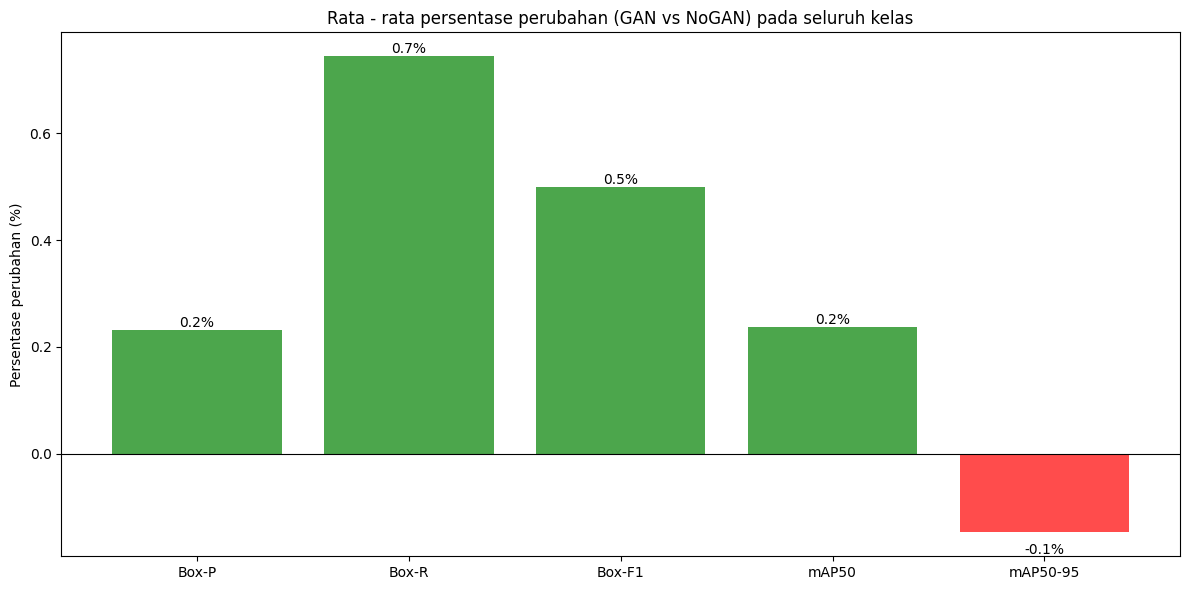

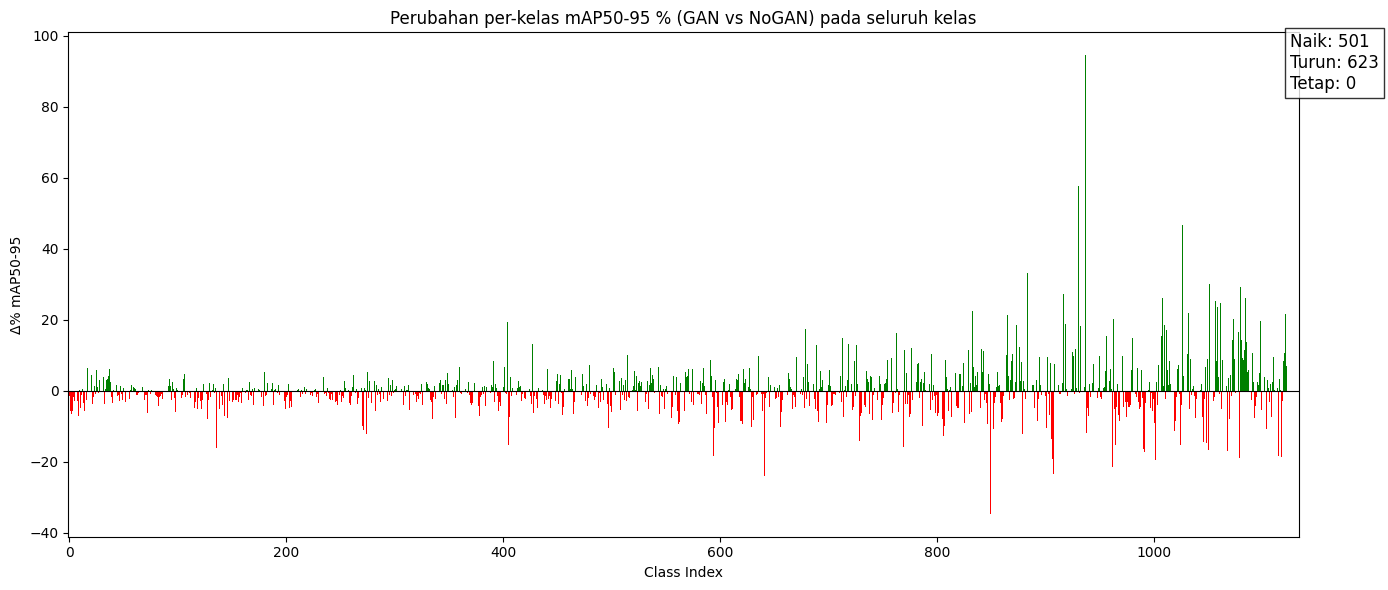


🔼 Top 10 Classes Improved by GAN (mAP50-95 %):
       Class  mAP50-95_Delta%
937   U+53E5        94.454713
931   U+73CD        57.672735
1027  U+89A7        46.743737
922   U+8A63        38.136652
935   U+90F7        35.064461
884   U+4E0E        33.215793
1042  U+964D        30.157333
1052  U+6674        29.895798
1080  U+86C7        29.119363
917   U+6469        27.267165

Top 10 Classes Hurt by GAN ({chosen_metric} %):
       Class  mAP50-95_Delta%
850   U+30B1       -34.721543
641   U+80B4       -23.972542
908   U+5EF6       -23.388104
962   U+89B3       -21.605433
529   U+85AC       -20.862205
1002  U+719F       -19.487927
907   U+56E3       -19.303364
1079  U+30D5       -18.908550
1118  U+6817       -18.800282
1115  U+90AA       -18.532625


In [4]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt

# Paths

# #YOLO v11
# csv_gan = "prev_runs/27-10_V11-500capGAN960imgsz100epochs/per_class_results.csv"
# csv_no_gan = "prev_runs/26-09_V11-500capNoGAN960imgsz100epochs/per_class_results.csv"

#YOLO v10
csv_gan = "prev_runs/01_11_V10-500capGAN960imgsz100epochs/per_class_results.csv"
csv_no_gan = "prev_runs/30_10_V10-500capNoGAN960imgsz100epochs/per_class_results.csv"

selected_folder = "../GAN/selected"   # your GAN-generated folder

# Load CSVsu
df_gan = pd.read_csv(csv_gan)
df_no_gan = pd.read_csv(csv_no_gan)

# Merge on Class
df = pd.merge(df_gan, df_no_gan, on="Class", suffixes=("_GAN", "_NoGAN"))

# Get list of GAN-augmented classes
selected_classes = [c for c in os.listdir(selected_folder) if os.path.isdir(os.path.join(selected_folder, c))]

# Filter
# df_filtered = df[df["Class"].isin(selected_classes)]
# df_filtered = df[~df["Class"].isin(selected_classes)]
df_filtered = df



# Metrics to compare
metrics = ["Box-P", "Box-R", "Box-F1", "mAP50", "mAP50-95"]

### Another another plot style

# Compute averages
gan_avgs = [df_filtered[f"{m}_GAN"].mean() for m in metrics]
nogan_avgs = [df_filtered[f"{m}_NoGAN"].mean() for m in metrics]

# print("Rata - rata metrik untuk kelas teraugmentasi:", gan_avgs)
# print("Rata - rata metrik untuk kelas tanpa GAN:", nogan_avgs)

# Compute percentage change
delta_percent = [(g - n) / n * 100 for g, n in zip(gan_avgs, nogan_avgs)]

# Plot percentage change
x = range(len(metrics))
plt.figure(figsize=(12,6))
bars = plt.bar(x, delta_percent, color=["green" if d > 0 else "red" for d in delta_percent], alpha=0.7)
plt.axhline(0, color="black", linewidth=0.8)
plt.xticks(x, metrics)
plt.ylabel("Persentase perubahan (%)")
plt.title("Rata - rata persentase perubahan (GAN vs NoGAN) pada seluruh kelas")
plt.tight_layout()

# Label bars with values
for i, d in enumerate(delta_percent):
    plt.text(i, d + (0 if d >= 0 else -0.02), f"{d:.1f}%", ha="center", va="bottom" if d >= 0 else "top")

plt.show()

#### Another another plot style

# Compute deltas (% change)
for metric in metrics:
    df_filtered[f"{metric}_Delta%"] = ((df_filtered[f"{metric}_GAN"] - df_filtered[f"{metric}_NoGAN"]) / df_filtered[f"{metric}_NoGAN"]) * 100

chosen_metric = "mAP50-95"

# ---- Plot per-class deltas for Chosen Metric ----
plt.figure(figsize=(14,6))

# Create a numeric index for x-axis
x_indices = range(len(df_filtered))

# Bar colors (green if improved, red if worsened)
colors = ["green" if x > 0 else "red" for x in df_filtered[f"{chosen_metric}_Delta%"]]

plt.bar(
    x_indices,
    df_filtered[f"{chosen_metric}_Delta%"],
    color=colors
)

plt.axhline(0, color="black", linewidth=0.8)
plt.title(f"Perubahan per-kelas {chosen_metric} % (GAN vs NoGAN) pada seluruh kelas")
plt.xlabel("Class Index")
plt.ylabel(f"Δ% {chosen_metric}")

# Count improved vs worsened
num_improved = (df_filtered[f"{chosen_metric}_Delta%"] > 0).sum()
num_worsened = (df_filtered[f"{chosen_metric}_Delta%"] < 0).sum()
num_unchanged = (df_filtered[f"{chosen_metric}_Delta%"] == 0).sum()

# Add text box on the right side
text_x = len(df_filtered) + 2  # slightly to the right of last bar
text_y = max(df_filtered[f"{chosen_metric}_Delta%"]) * 0.9  # near top of plot
stats_text = (
    f"Naik: {num_improved}\n"
    f"Turun: {num_worsened}\n"
    f"Tetap: {num_unchanged}"
)

plt.text(
    text_x, text_y,
    stats_text,
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8)
)

# Adjust x limits to make room for the text box
plt.xlim(-1, len(df_filtered) + 10)

plt.tight_layout()
plt.show()


# ---- Print top improvements and declines ----
print(f"\n🔼 Top 10 Classes Improved by GAN ({chosen_metric} %):")
print(df_filtered.sort_values(f"{chosen_metric}_Delta%", ascending=False)[["Class", f"{chosen_metric}_Delta%"]].head(10))

print("\nTop 10 Classes Hurt by GAN ({chosen_metric} %):")
print(df_filtered.sort_values(f"{chosen_metric}_Delta%", ascending=True)[["Class", f"{chosen_metric}_Delta%"]].head(10))


### Rata - rata persentase perubahan pada kelas TIDAK teraugmentasi 

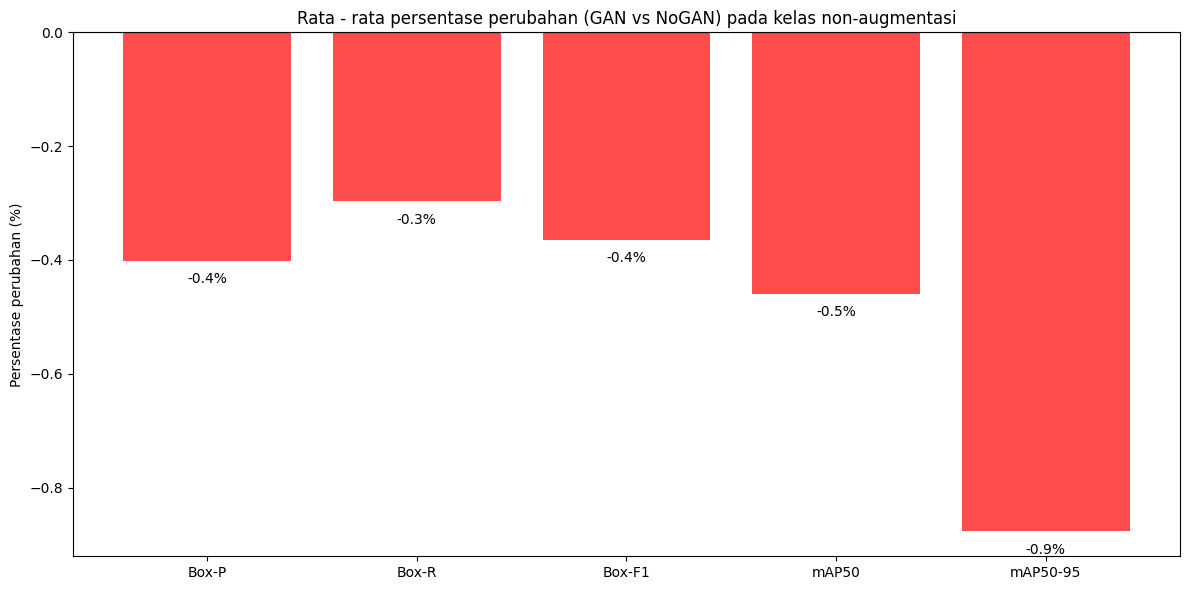

C:\Users\aktsa_wi2suow\AppData\Local\Temp\ipykernel_1728\1479353897.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f"{metric}_Delta%"] = ((df_filtered[f"{metric}_GAN"] - df_filtered[f"{metric}_NoGAN"]) / df_filtered[f"{metric}_NoGAN"]) * 100
C:\Users\aktsa_wi2suow\AppData\Local\Temp\ipykernel_1728\1479353897.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f"{metric}_Delta%"] = ((df_filtered[f"{metric}_GAN"] - df_filtered[f"{metric}_NoGAN"]) / df_filtered[f"{metric}_NoGAN"]

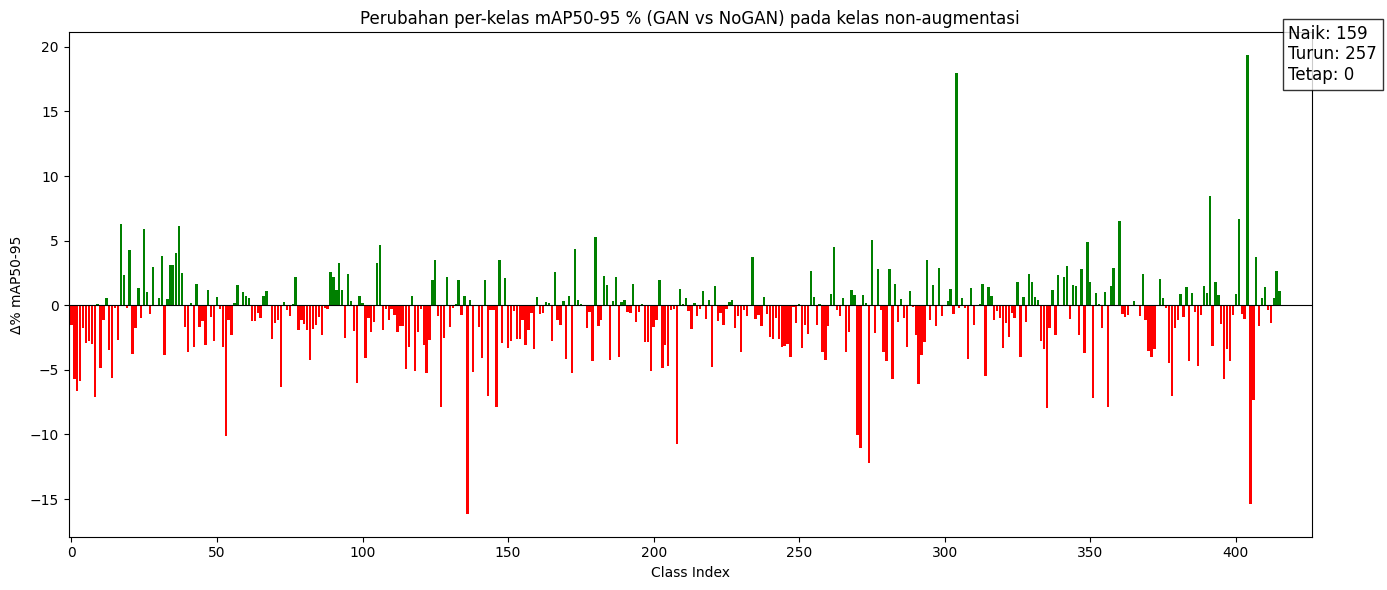


🔼 Top 10 Classes Improved by GAN (mAP50-95 %):
      Class  mAP50-95_Delta%
404  U+79CB        19.349551
304  U+30D0        17.957504
391  U+5143         8.449812
401  U+52E2         6.704409
360  U+5CF6         6.516652
17   U+308C         6.261650
37   U+309D         6.157324
25   U+3075         5.912637
180  U+6C41         5.267110
275  U+571F         5.087561

Top 10 Classes Hurt by GAN ({chosen_metric} %):
      Class  mAP50-95_Delta%
136  U+30FD       -16.144983
405  U+96E8       -15.417547
274  U+5F62       -12.218341
271  U+677E       -11.066629
208  U+7406       -10.748669
53   U+305A       -10.131789
270  U+4F5C       -10.008869
335  U+53C2        -7.931998
127  U+309E        -7.880640
356  U+91CD        -7.870350


In [2]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt

# Paths

# #YOLO v11
# csv_gan = "prev_runs/27-10_V11-500capGAN960imgsz100epochs/per_class_results.csv"
# csv_no_gan = "prev_runs/26-09_V11-500capNoGAN960imgsz100epochs/per_class_results.csv"

#YOLO v10
csv_gan = "prev_runs/01_11_V10-500capGAN960imgsz100epochs/per_class_results.csv"
csv_no_gan = "prev_runs/30_10_V10-500capNoGAN960imgsz100epochs/per_class_results.csv"

selected_folder = "../GAN/selected"   # your GAN-generated folder

# Load CSVsu
df_gan = pd.read_csv(csv_gan)
df_no_gan = pd.read_csv(csv_no_gan)

# Merge on Class
df = pd.merge(df_gan, df_no_gan, on="Class", suffixes=("_GAN", "_NoGAN"))

# Get list of GAN-augmented classes
selected_classes = [c for c in os.listdir(selected_folder) if os.path.isdir(os.path.join(selected_folder, c))]

# Filter
# df_filtered = df[df["Class"].isin(selected_classes)]
df_filtered = df[~df["Class"].isin(selected_classes)]
# df_filtered = df



# Metrics to compare
metrics = ["Box-P", "Box-R", "Box-F1", "mAP50", "mAP50-95"]

### Another another plot style

# Compute averages
gan_avgs = [df_filtered[f"{m}_GAN"].mean() for m in metrics]
nogan_avgs = [df_filtered[f"{m}_NoGAN"].mean() for m in metrics]

# print("Rata - rata metrik untuk kelas teraugmentasi:", gan_avgs)
# print("Rata - rata metrik untuk kelas tanpa GAN:", nogan_avgs)

# Compute percentage change
delta_percent = [(g - n) / n * 100 for g, n in zip(gan_avgs, nogan_avgs)]

# Plot percentage change
x = range(len(metrics))
plt.figure(figsize=(12,6))
bars = plt.bar(x, delta_percent, color=["green" if d > 0 else "red" for d in delta_percent], alpha=0.7)
plt.axhline(0, color="black", linewidth=0.8)
plt.xticks(x, metrics)
plt.ylabel("Persentase perubahan (%)")
plt.title("Rata - rata persentase perubahan (GAN vs NoGAN) pada kelas non-augmentasi")
plt.tight_layout()

# Label bars with values
for i, d in enumerate(delta_percent):
    plt.text(i, d + (0 if d >= 0 else -0.02), f"{d:.1f}%", ha="center", va="bottom" if d >= 0 else "top")

plt.show()

#### Another another plot style

# Compute deltas (% change)
for metric in metrics:
    df_filtered[f"{metric}_Delta%"] = ((df_filtered[f"{metric}_GAN"] - df_filtered[f"{metric}_NoGAN"]) / df_filtered[f"{metric}_NoGAN"]) * 100

chosen_metric = "mAP50-95"

# ---- Plot per-class deltas for Chosen Metric ----
plt.figure(figsize=(14,6))

# Create a numeric index for x-axis
x_indices = range(len(df_filtered))

# Bar colors (green if improved, red if worsened)
colors = ["green" if x > 0 else "red" for x in df_filtered[f"{chosen_metric}_Delta%"]]

plt.bar(
    x_indices,
    df_filtered[f"{chosen_metric}_Delta%"],
    color=colors
)

plt.axhline(0, color="black", linewidth=0.8)
plt.title(f"Perubahan per-kelas {chosen_metric} % (GAN vs NoGAN) pada kelas non-augmentasi")
plt.xlabel("Class Index")
plt.ylabel(f"Δ% {chosen_metric}")

# Count improved vs worsened
num_improved = (df_filtered[f"{chosen_metric}_Delta%"] > 0).sum()
num_worsened = (df_filtered[f"{chosen_metric}_Delta%"] < 0).sum()
num_unchanged = (df_filtered[f"{chosen_metric}_Delta%"] == 0).sum()

# Add text box on the right side
text_x = len(df_filtered) + 2  # slightly to the right of last bar
text_y = max(df_filtered[f"{chosen_metric}_Delta%"]) * 0.9  # near top of plot
stats_text = (
    f"Naik: {num_improved}\n"
    f"Turun: {num_worsened}\n"
    f"Tetap: {num_unchanged}"
)

plt.text(
    text_x, text_y,
    stats_text,
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8)
)

# Adjust x limits to make room for the text box
plt.xlim(-1, len(df_filtered) + 10)

plt.tight_layout()
plt.show()


# ---- Print top improvements and declines ----
print(f"\n🔼 Top 10 Classes Improved by GAN ({chosen_metric} %):")
print(df_filtered.sort_values(f"{chosen_metric}_Delta%", ascending=False)[["Class", f"{chosen_metric}_Delta%"]].head(10))

print("\nTop 10 Classes Hurt by GAN ({chosen_metric} %):")
print(df_filtered.sort_values(f"{chosen_metric}_Delta%", ascending=True)[["Class", f"{chosen_metric}_Delta%"]].head(10))


## Test Prediction

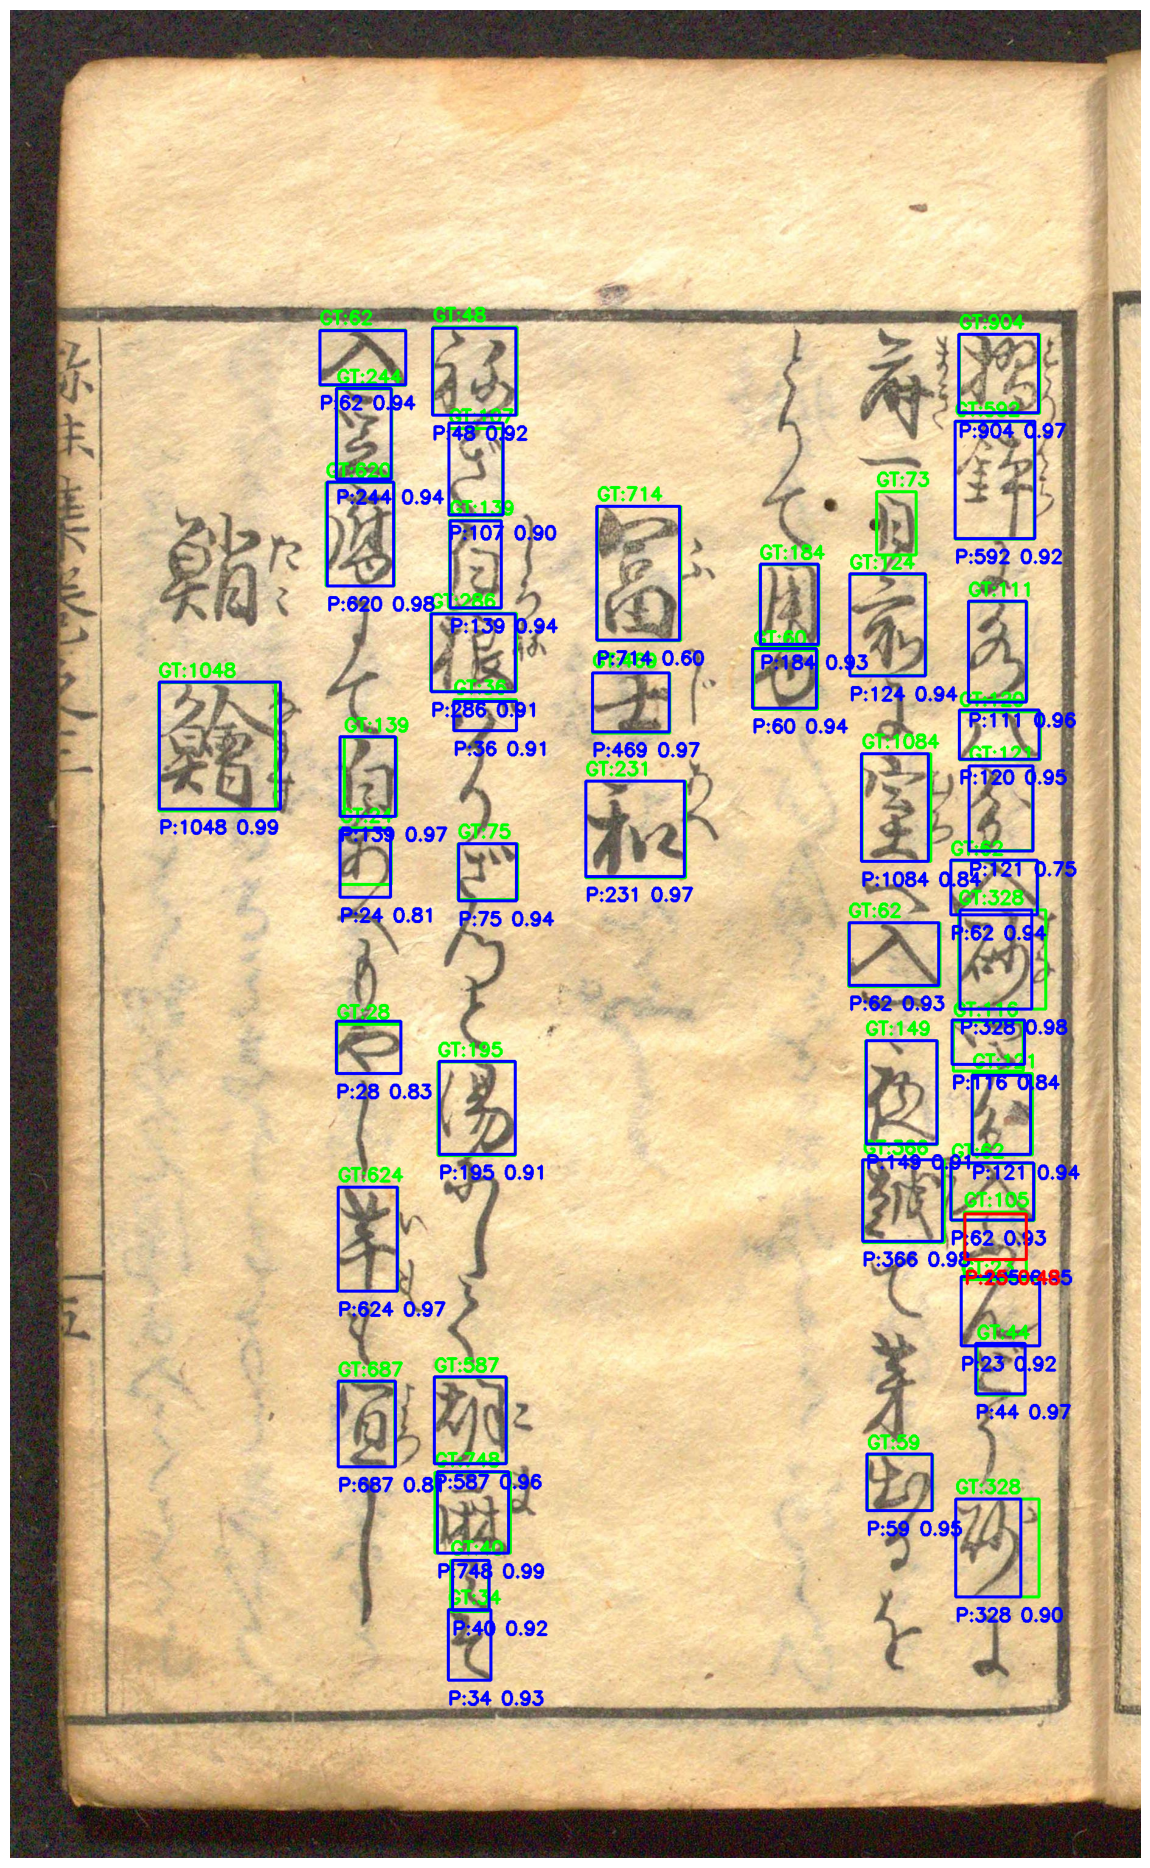

Inference time: 0.1898 seconds


In [1]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import time

# --- IoU helper ---
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1, yi1 = max(x1, x1g), max(y1, y1g)
    xi2, yi2 = min(x2, x2g), min(y2, y2g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = max(0, (x2 - x1)) * max(0, (y2 - y1))
    box2_area = max(0, (x2g - x1g)) * max(0, (y2g - y1g))
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0\
    
# --- Draw Japanese Unicode text on OpenCV image ---

def draw_unicode_text(img, text, position, font_path="C:\\Windows\\Fonts\\BIZ-UDGOTHICR.ttc", font_size=32, color=(0, 255, 0)):
    # Convert OpenCV image (BGR) to PIL image (RGB)
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)

    # Load a font that supports Japanese/kanji
    font = ImageFont.truetype(font_path, font_size)

    # Draw the text
    draw.text(position, text, font=font, fill=color)

    # Convert back to OpenCV (BGR)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# --- Load class report (map ID -> Unicode) ---
class_report = pd.read_csv("yolo_kuzushiji/yolo_kuzushiji_cut/class_report.csv")  # adjust path
id_to_unicode = {
    int(row["ClassID"]): chr(int(str(row["Unicode"]).replace("U+", ""), 16))
    for _, row in class_report.iterrows()
}

# Paths
img_path = "yolo_kuzushiji_cut_split/validation/images/100249537_00059_2.jpg"
label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
model = YOLO("prev_runs/27-10_V11-500capGAN960imgsz100epochs/weights/best.pt")

model.predict(img_path, verbose=False)

# --- Load image ---
img = cv2.imread(img_path)
h, w, _ = img.shape

# --- Ground truth ---
gt_boxes = []
if os.path.exists(label_path):
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, x_center, y_center, bw, bh = map(float, line.strip().split())
            x1 = int((x_center - bw / 2) * w)
            y1 = int((y_center - bh / 2) * h)
            x2 = int((x_center + bw / 2) * w)
            y2 = int((y_center + bh / 2) * h)
            gt_boxes.append((int(cls), (x1, y1, x2, y2)))

            # draw GT box
            label = id_to_unicode.get(int(cls), str(int(cls)))
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)  # green
            cv2.putText(img, f"GT:{int(cls)}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
            # img = draw_unicode_text(img, f"GT:{label}", (x1, y1 - 10), font_size=10, color=(0, 255, 0))

# --- Predictions ---
start = time.time()
results = model.predict(img_path, conf=0.25, verbose=False)
end = time.time()

for r in results:
    boxes = r.boxes.xyxy.cpu().numpy()
    confs = r.boxes.conf.cpu().numpy()
    clss = r.boxes.cls.cpu().numpy()

    for box, conf, cls in zip(boxes, confs, clss):
        x1, y1, x2, y2 = map(int, box)
        cls = int(cls)
        label = id_to_unicode.get(cls, str(cls))

        # check if matches any GT
        match = False
        for gt_cls, gt_box in gt_boxes:
            if gt_cls == cls and compute_iou((x1, y1, x2, y2), gt_box) >= 0.5:
                match = True
                break

        color = (255, 0, 0) if match else (0, 0, 255)  # blue if correct, red if wrong
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
        cv2.putText(img, f"P:{int(cls)} {conf:.2f}", (x1, y2 + 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)
        # img = draw_unicode_text(img, f"P:{label} {conf:.2f}", (x1, y2 + 20), font_size=40, color=color)

# --- Show image ---
plt.figure(figsize=(24, 24))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print(f"Inference time: {end - start:.4f} seconds")


# YOLO V10

## Yolo Train

In [1]:
from ultralytics import YOLO

model = YOLO("yolo10m.pt")

# Train
model.train(
    seed=420,
    data="yolo_kuzushiji_cut_split_gan_augment/data.yaml",  # dataset yaml
    epochs=100,
    imgsz=960,
    batch=4,
    name="kuzushiji_GAN_tuned",
    translate=0.05,
    scale=0.15,
    degrees=7,
    optimizer='SGD',
    # fliplr=0.5,   
    mosaic=0.2,
    hsv_v=0.5,
    erasing=0.2,
    cache=False,
    cos_lr=True,            # cosine learning rate schedule
    patience=50 
)

# model.train(
#     data="yolo_kuzushiji_cut_split/data.yaml",  # dataset yaml
#     epochs=100,
#     imgsz=960,
#     batch=4,
#     name="kuzushiji_noGAN",
#     translate=0.1,
#     scale=0.15,
#     degrees=10,
#     # fliplr=0.5,   
#     # mosaic=0.0,
#     hsv_v=0.5,
#     erasing=0.2,
#     cache=False,
#     cos_lr=True,
# )

New https://pypi.org/project/ultralytics/8.3.222 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.160  Python-3.13.0 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=yolo_kuzushiji_cut_split_gan_augment/data.yaml, degrees=7, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.2, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.5, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo10m.pt, momentum=0.937, mosaic=0.2, multi_scale=False, name=kuzushi

train: Scanning C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split_gan_augment\train\labels.cache... 5782 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5782/5782 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 412.430.1 MB/s, size: 669.0 KB)


val: Scanning C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split_gan_augment\validation\labels.cache... 1096 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1096/1096 [00:00<?, ?it/s]


Plotting labels to runs\detect\kuzushiji_GAN_tuned\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)
Image sizes 960 train, 960 val
Using 8 dataloader workers
Logging results to runs\detect\kuzushiji_GAN_tuned
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.36G      1.558      10.63      1.778         45        960: 100%|██████████| 1446/1446 [19:43<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.595     0.0339     0.0196     0.0157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.26G      1.448      6.988      1.704         65        960: 100%|██████████| 1446/1446 [26:56<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.383      0.157      0.123      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.34G      1.509      4.943      1.714         85        960: 100%|██████████| 1446/1446 [26:56<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.14it/s]


                   all       1096      50276      0.372      0.301       0.28      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       8.3G       1.45      3.715      1.705         47        960: 100%|██████████| 1446/1446 [24:37<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:03<00:00,  2.14it/s]


                   all       1096      50276      0.482      0.423      0.432       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       8.3G       1.34      2.934      1.681        135        960: 100%|██████████| 1446/1446 [26:42<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:03<00:00,  2.16it/s]


                   all       1096      50276      0.569        0.5      0.538      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.33G      1.251      2.455      1.665         85        960: 100%|██████████| 1446/1446 [27:29<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.11it/s]


                   all       1096      50276      0.618      0.551       0.61      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.33G      1.195      2.158      1.657        146        960: 100%|██████████| 1446/1446 [26:22<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:03<00:00,  2.15it/s]


                   all       1096      50276      0.666      0.576      0.652      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.39G      1.142      1.943      1.646        132        960: 100%|██████████| 1446/1446 [25:39<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.696      0.624      0.698      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.35G      1.106      1.795       1.64        114        960: 100%|██████████| 1446/1446 [27:01<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.716      0.639      0.721      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.35G      1.067      1.643      1.633        104        960: 100%|██████████| 1446/1446 [25:42<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.13it/s]


                   all       1096      50276      0.739      0.661      0.746      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.34G       1.05      1.538       1.63         86        960: 100%|██████████| 1446/1446 [27:21<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276       0.75      0.687      0.769       0.68

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.38G      1.021      1.446      1.625        102        960: 100%|██████████| 1446/1446 [26:10<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.11it/s]


                   all       1096      50276      0.758       0.69      0.777      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.36G      1.005      1.363      1.621        136        960: 100%|██████████| 1446/1446 [28:01<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.11it/s]


                   all       1096      50276      0.776      0.707      0.795      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.34G      0.976      1.309      1.617         94        960: 100%|██████████| 1446/1446 [24:52<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.13it/s]


                   all       1096      50276      0.794      0.721       0.81      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       8.3G     0.9623      1.241      1.615         32        960: 100%|██████████| 1446/1446 [25:02<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.802      0.712       0.81      0.713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.36G     0.9548      1.214      1.614        151        960: 100%|██████████| 1446/1446 [28:25<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.801      0.734      0.822      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.36G     0.9326       1.18      1.609         62        960: 100%|██████████| 1446/1446 [26:13<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.14it/s]


                   all       1096      50276      0.803      0.744      0.828      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.28G     0.9252      1.127      1.608         59        960: 100%|██████████| 1446/1446 [27:49<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.14it/s]


                   all       1096      50276      0.809      0.745      0.832      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.43G     0.9208      1.083      1.607         72        960: 100%|██████████| 1446/1446 [27:12<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.13it/s]


                   all       1096      50276      0.814      0.765      0.847      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.35G     0.9004      1.025      1.603        155        960: 100%|██████████| 1446/1446 [26:36<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:03<00:00,  2.14it/s]


                   all       1096      50276      0.825      0.768      0.851      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.48G     0.8814     0.9939      1.601         40        960: 100%|██████████| 1446/1446 [29:33<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.837      0.769      0.854      0.764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.24G     0.8777     0.9971      1.601        137        960: 100%|██████████| 1446/1446 [25:40<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.14it/s]


                   all       1096      50276      0.838      0.767      0.858       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.29G     0.8709          1        1.6        132        960: 100%|██████████| 1446/1446 [26:28<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.13it/s]


                   all       1096      50276      0.835      0.778       0.86      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.43G     0.8603     0.9419      1.598         43        960: 100%|██████████| 1446/1446 [27:24<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.14it/s]


                   all       1096      50276      0.847      0.782      0.867      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       8.3G      0.859     0.9282      1.597         94        960: 100%|██████████| 1446/1446 [26:13<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.14it/s]


                   all       1096      50276      0.845      0.788       0.87      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.32G     0.8466     0.8769      1.595         39        960: 100%|██████████| 1446/1446 [27:41<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.11it/s]


                   all       1096      50276      0.844      0.791      0.871      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.42G     0.8303     0.8743      1.592        216        960: 100%|██████████| 1446/1446 [27:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.13it/s]


                   all       1096      50276      0.857      0.796       0.88      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       8.3G     0.8324     0.8437      1.593         93        960: 100%|██████████| 1446/1446 [26:35<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.858      0.797       0.88      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       8.3G     0.8102     0.8098      1.588        146        960: 100%|██████████| 1446/1446 [26:27<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.866      0.802      0.884      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.23G     0.8203     0.7806      1.587        283        960:  14%|█▍        | 203/1446 [03:50<23:30,  1.13s/it]


KeyboardInterrupt: 

Resume training if interrupted

In [1]:
from ultralytics import YOLO

model = YOLO('./runs/detect/kuzushiji_GAN_tuned/weights/last.pt')
# Train
model.train(
    seed=420,
    data="yolo_kuzushiji_cut_split_gan_augment/data.yaml",  # dataset yaml
    epochs=100,
    imgsz=960,
    batch=4,
    name="kuzushiji_GAN_tuned",
    translate=0.05,
    scale=0.15,
    degrees=7,
    optimizer='SGD',
    # fliplr=0.5,   
    mosaic=0.2,
    hsv_v=0.5,
    erasing=0.2,
    cache=False,
    cos_lr=True,            # cosine learning rate schedule
    patience=50, 
    resume=True
)
# # resume train the model
# model.train(
#     data="yolo_kuzushiji_cut_split/data.yaml",  # dataset yaml
#     epochs=100,
#     imgsz=640,
#     batch=8,
#     name="kuzushiji",
#     translate=0.1,
#     scale=0.3,
#     degrees=30,
#     # fliplr=0.5,   
#     # mosaic=0.0,
#     hsv_v=0.5,
#     erasing=0.2,
#     resume=True
# )

New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.160  Python-3.13.0 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=yolo_kuzushiji_cut_split_gan_augment/data.yaml, degrees=7, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.2, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.5, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs\detect\kuzushiji_GAN_tuned\weights\last.pt, momentum=0.937, mosaic

train: Scanning C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split_gan_augment\train\labels.cache... 5782 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5782/5782 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 778.8558.9 MB/s, size: 669.0 KB)


val: Scanning C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split_gan_augment\validation\labels.cache... 1096 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1096/1096 [00:00<?, ?it/s]


Plotting labels to runs\detect\kuzushiji_GAN_tuned\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)
Resuming training runs\detect\kuzushiji_GAN_tuned\weights\last.pt from epoch 82 to 100 total epochs
Image sizes 960 train, 960 val
Using 8 dataloader workers
Logging results to runs\detect\kuzushiji_GAN_tuned
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.31G     0.5755     0.3802      1.546         45        960: 100%|██████████| 1446/1446 [21:08<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:06<00:00,  2.05it/s]


                   all       1096      50276      0.905      0.863      0.925      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.26G      0.575      0.379      1.546         65        960: 100%|██████████| 1446/1446 [23:46<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:09<00:00,  1.97it/s]


                   all       1096      50276      0.909      0.861      0.924      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.31G     0.5719     0.3793      1.546         85        960: 100%|██████████| 1446/1446 [30:59<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:05<00:00,  2.09it/s]


                   all       1096      50276      0.905      0.863      0.924      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.31G     0.5701     0.3754      1.547         47        960: 100%|██████████| 1446/1446 [29:17<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.13it/s]


                   all       1096      50276      0.906      0.861      0.924      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       8.3G     0.5698      0.377      1.545        135        960: 100%|██████████| 1446/1446 [24:35<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:08<00:00,  2.00it/s]


                   all       1096      50276      0.903      0.864      0.924      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.33G     0.5618     0.3669      1.544         85        960: 100%|██████████| 1446/1446 [23:50<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.908       0.86      0.924      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.37G      0.565     0.3709      1.546        146        960: 100%|██████████| 1446/1446 [24:05<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.909       0.86      0.924      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.38G     0.5594      0.367      1.543        132        960: 100%|██████████| 1446/1446 [23:53<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.907       0.86      0.924      0.852

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.34G     0.5647     0.3689      1.545        114        960: 100%|██████████| 1446/1446 [25:30<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276       0.91      0.859      0.924      0.853
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.27G     0.5548     0.3269       1.54         75        960: 100%|██████████| 1446/1446 [26:21<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.14it/s]


                   all       1096      50276      0.908      0.861      0.924      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.28G     0.5533     0.3258       1.54        122        960: 100%|██████████| 1446/1446 [26:11<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.909       0.86      0.924      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.29G     0.5536     0.3245      1.539        131        960: 100%|██████████| 1446/1446 [25:11<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:06<00:00,  2.05it/s]


                   all       1096      50276      0.905      0.861      0.923      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       8.3G     0.5526     0.3222       1.54         68        960: 100%|██████████| 1446/1446 [24:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.904      0.863      0.924      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.32G     0.5511     0.3217       1.54         58        960: 100%|██████████| 1446/1446 [23:24<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.13it/s]


                   all       1096      50276      0.909      0.858      0.924      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.28G      0.552     0.3232      1.539         82        960: 100%|██████████| 1446/1446 [25:11<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.14it/s]


                   all       1096      50276      0.911      0.857      0.923      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.28G     0.5475     0.3184      1.539        145        960: 100%|██████████| 1446/1446 [25:00<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.911      0.856      0.924      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.38G     0.5476     0.3164      1.539         96        960: 100%|██████████| 1446/1446 [23:15<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.13it/s]


                   all       1096      50276      0.909      0.858      0.924      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.37G     0.5461     0.3173      1.538        139        960: 100%|██████████| 1446/1446 [23:34<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:04<00:00,  2.12it/s]


                   all       1096      50276      0.909      0.857      0.924      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.24G      0.547     0.3161      1.539         78        960: 100%|██████████| 1446/1446 [25:48<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:03<00:00,  2.14it/s]


                   all       1096      50276      0.905      0.862      0.924      0.853

19 epochs completed in 8.294 hours.
Optimizer stripped from runs\detect\kuzushiji_GAN_tuned\weights\last.pt, 36.1MB
Optimizer stripped from runs\detect\kuzushiji_GAN_tuned\weights\best.pt, 36.1MB

Validating runs\detect\kuzushiji_GAN_tuned\weights\best.pt...
Ultralytics 8.3.160  Python-3.13.0 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 8192MiB)
YOLOv10m summary (fused): 136 layers, 15,963,964 parameters, 0 gradients, 62.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:36<00:00,  3.74it/s]


                   all       1096      50276      0.906      0.863      0.925      0.854
                U+306E         17        100      0.923      0.844      0.929       0.85
                U+306B         18         93      0.749      0.871      0.883      0.758
                U+3057         19         94      0.781      0.777      0.831      0.582
                U+3066         24        105      0.904      0.901      0.925      0.795
                U+3068         38         96      0.966      0.889      0.948      0.813
                U+304B         40        103      0.897      0.845      0.927      0.713
                U+306F         38        104       0.98      0.945      0.973      0.815
                U+3092         22        100      0.884       0.98      0.942      0.861
                U+308A         21        106      0.798      0.962       0.87      0.739
                U+306A         32         98      0.915      0.876      0.942       0.83
                U+308

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([   0,    1,    2, ..., 1121, 1122, 1123])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020E2B553890>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0

# Comparison

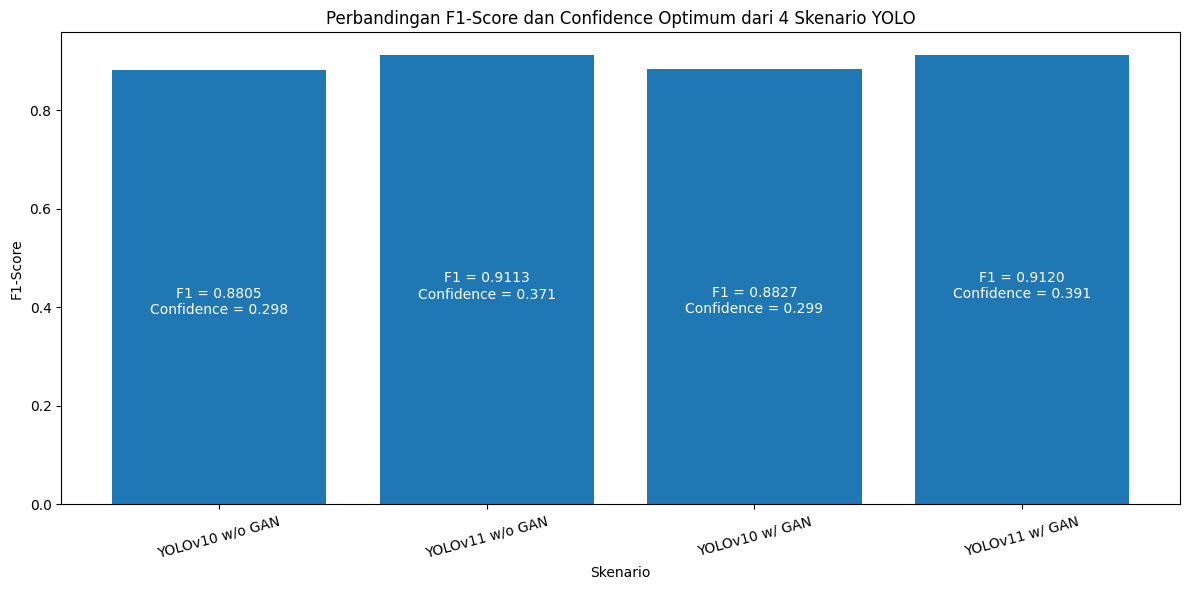


=== MODEL PERFORMANCE SUMMARY ===

▶ YOLOv10 w/o GAN
   Precision   : 0.9091
   Recall      : 0.8538
   F1-score    : 0.8805
   mAP50       : 0.9227
   mAP50-95    : 0.8539
   Train Time  : 113772.29 sec (31.60 hours)

▶ YOLOv11 w/o GAN
   Precision   : 0.9357
   Recall      : 0.8882
   F1-score    : 0.9113
   mAP50       : 0.9464
   mAP50-95    : 0.8697
   Train Time  : 74183.25 sec (20.61 hours)

▶ YOLOv10 w/ GAN
   Precision   : 0.9048
   Recall      : 0.8617
   F1-score    : 0.8827
   mAP50       : 0.9239
   mAP50-95    : 0.8534
   Train Time  : 163269.44 sec (45.35 hours)

▶ YOLOv11 w/ GAN
   Precision   : 0.9340
   Recall      : 0.8910
   F1-score    : 0.9120
   mAP50       : 0.9472
   mAP50-95    : 0.8684
   Train Time  : 104099.80 sec (28.92 hours)



In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# === CSV paths for each scenario ===
csv_files = {
    "YOLOv10 w/o GAN": "./prev_runs/30_10_V10-500capNoGAN960imgsz100epochs/results.csv",
    "YOLOv11 w/o GAN": "./prev_runs/26-09_V11-500capNoGAN960imgsz100epochs/results.csv",
    "YOLOv10 w/ GAN" : "./prev_runs/01_11_V10-500capGAN960imgsz100epochs/results.csv",
    "YOLOv11 w/ GAN" : "./prev_runs/27-10_V11-500capGAN960imgsz100epochs/results.csv",
}

# === Best confidence values taken from YOLO F1 curve ===
confidence = {
    "YOLOv10 w/o GAN": 0.298,
    "YOLOv11 w/o GAN": 0.371,
    "YOLOv10 w/ GAN": 0.299,
    "YOLOv11 w/ GAN": 0.391
}

f1_scores = {}

def compute_total_training_time(csv_path):
    df = pd.read_csv(csv_path)

    # Extract the time column as a list
    times = df["time"].tolist()

    total = 0.0

    for i in range(1, len(times)):
        prev = times[i - 1]
        curr = times[i]

        if curr >= prev:
            # Normal case: cumulative increasing
            total += (curr - prev)
        else:
            # Reset detected (resumed training)
            # curr is starting again from ~0
            total += curr  # add starting segment

    return total

def compute_f1(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# === Read CSV and compute F1-score ===
for label, path in csv_files.items():
    df = pd.read_csv(path)
    last = df.iloc[-1]       # latest epoch
    precision = last["metrics/precision(B)"]
    recall = last["metrics/recall(B)"]

    f1 = compute_f1(precision, recall)
    f1_scores[label] = f1

# === Plot the comparison ===
plt.figure(figsize=(12, 6))
bars = plt.bar(f1_scores.keys(), f1_scores.values())

# Add text: F1 + confidence on the bars
for bar, label in zip(bars, f1_scores.keys()):
    height = bar.get_height()
    conf = confidence[label]

    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height - 0.5,
        f"F1 = {height:.4f}\nConfidence = {conf:.3f}",
        ha="center",
        va="bottom",
        fontsize=10,
        color="white" 
    )

plt.title("Perbandingan F1-Score dan Confidence Optimum dari 4 Skenario YOLO")
plt.xlabel("Skenario")
plt.ylabel("F1-Score")
plt.xticks(rotation=15)
plt.tight_layout()

plt.savefig("Model performances f1-score.png", dpi=300)
plt.show()

print("\n=== MODEL PERFORMANCE SUMMARY ===\n")

for name, path in csv_files.items():
    df = pd.read_csv(path)
    last = df.iloc[-1]

    precision = last["metrics/precision(B)"]
    recall = last["metrics/recall(B)"]
    f1 = compute_f1(precision, recall)

    map50 = last["metrics/mAP50(B)"]
    map5095 = last["metrics/mAP50-95(B)"]

    total_seconds = compute_total_training_time(path)
    hours = total_seconds / 3600

    print(f"▶ {name}")
    print(f"   Precision   : {precision:.4f}")
    print(f"   Recall      : {recall:.4f}")
    print(f"   F1-score    : {f1:.4f}")
    print(f"   mAP50       : {map50:.4f}")
    print(f"   mAP50-95    : {map5095:.4f}")
    print(f"   Train Time  : {total_seconds:.2f} sec ({hours:.2f} hours)")
    print("")


# Improvement

YOLO Training

In [1]:
from ultralytics import YOLO

model = YOLO("yolo11m.pt")
# YOLO V11 w/o GAN Augmentation 

# Train
model.train(
    seed=420,
    data="yolo_kuzushiji_cut_split_grid_gan_augment/data.yaml",  # dataset yaml
    epochs=100,
    imgsz=960,
    batch=4,
    name="kuzushiji_grid_GAN_tuned",
    translate=0.05,
    scale=0.15,
    degrees=7,
    optimizer='SGD',
    # fliplr=0.5,   
    mosaic=0.2,
    hsv_v=0.5,
    erasing=0.2,
    cache=False,
    cos_lr=True,            # cosine learning rate schedule
    patience=50 
)

New https://pypi.org/project/ultralytics/8.3.226 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.160  Python-3.13.0 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=yolo_kuzushiji_cut_split_grid_gan_augment/data.yaml, degrees=7, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.2, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.5, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=0.2, multi_scale=False, name=ku

train: Scanning C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split_grid_gan_augment\train\labels... 5083 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5083/5083 [00:14<00:00, 343.06it/s]


train: New cache created: C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split_grid_gan_augment\train\labels.cache
val: Fast image access  (ping: 0.30.1 ms, read: 39.65.2 MB/s, size: 663.4 KB)


val: Scanning C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split_grid_gan_augment\validation\labels... 1096 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1096/1096 [00:03<00:00, 295.76it/s]


val: New cache created: C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split_grid_gan_augment\validation\labels.cache
Plotting labels to runs\detect\kuzushiji_grid_GAN_tuned\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 960 train, 960 val
Using 8 dataloader workers
Logging results to runs\detect\kuzushiji_grid_GAN_tuned
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.37G     0.8311       5.11     0.8996        168        960: 100%|██████████| 1271/1271 [09:53<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:55<00:00,  2.47it/s]


                   all       1096      50276      0.476     0.0826     0.0628     0.0509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.49G     0.7439      3.061     0.8619        145        960: 100%|██████████| 1271/1271 [09:52<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:17<00:00,  1.78it/s]


                   all       1096      50276      0.425       0.29      0.267      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.56G      0.771      2.125      0.868        340        960: 100%|██████████| 1271/1271 [09:59<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:48<00:00,  2.81it/s]


                   all       1096      50276      0.492      0.422      0.433      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.44G     0.7394       1.62     0.8625         77        960: 100%|██████████| 1271/1271 [09:57<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:45<00:00,  3.04it/s]


                   all       1096      50276       0.64      0.545      0.609      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       7.4G     0.6837      1.295       0.85        294        960: 100%|██████████| 1271/1271 [09:59<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:44<00:00,  3.05it/s]


                   all       1096      50276      0.701      0.604      0.684      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.52G      0.639        1.1      0.841        202        960: 100%|██████████| 1271/1271 [09:52<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:43<00:00,  3.17it/s]


                   all       1096      50276       0.74      0.649      0.732      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.54G     0.6022     0.9851     0.8333        200        960: 100%|██████████| 1271/1271 [10:12<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.21it/s]


                   all       1096      50276       0.76      0.679      0.763      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.42G     0.5783     0.9067     0.8285        206        960: 100%|██████████| 1271/1271 [09:50<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:43<00:00,  3.16it/s]


                   all       1096      50276      0.782      0.696      0.785      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.39G     0.5587     0.8289     0.8254        282        960: 100%|██████████| 1271/1271 [09:50<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:43<00:00,  3.14it/s]


                   all       1096      50276      0.814      0.725      0.817      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.51G     0.5383     0.7843     0.8218        188        960: 100%|██████████| 1271/1271 [17:55<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:26<00:00,  1.59it/s]


                   all       1096      50276      0.804       0.74      0.825       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.38G     0.5272     0.7396     0.8192        247        960: 100%|██████████| 1271/1271 [18:27<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:44<00:00,  3.05it/s]


                   all       1096      50276      0.825      0.758      0.842      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.48G     0.5098      0.711     0.8169        197        960: 100%|██████████| 1271/1271 [10:13<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:12<00:00,  1.90it/s]


                   all       1096      50276      0.827      0.757      0.843      0.735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.47G     0.5051     0.6714     0.8148        186        960: 100%|██████████| 1271/1271 [10:18<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:07<00:00,  2.02it/s]


                   all       1096      50276       0.84       0.78      0.862      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.44G     0.4943     0.6409     0.8128        300        960: 100%|██████████| 1271/1271 [10:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:15<00:00,  1.83it/s]


                   all       1096      50276      0.843      0.783      0.865      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.37G     0.4802     0.6165     0.8107        250        960: 100%|██████████| 1271/1271 [11:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:43<00:00,  3.18it/s]


                   all       1096      50276       0.85      0.781      0.871      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.37G     0.4737     0.5979     0.8093        220        960: 100%|██████████| 1271/1271 [10:07<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.29it/s]


                   all       1096      50276      0.854      0.798      0.876      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.45G      0.471     0.5793     0.8089        124        960: 100%|██████████| 1271/1271 [10:06<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.23it/s]


                   all       1096      50276      0.852        0.8       0.88      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.43G     0.4578     0.5625     0.8069        141        960: 100%|██████████| 1271/1271 [10:04<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:50<00:00,  2.71it/s]


                   all       1096      50276       0.86      0.803      0.884      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.49G     0.4551     0.5416      0.806        110        960: 100%|██████████| 1271/1271 [10:13<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.20it/s]


                   all       1096      50276      0.861      0.815      0.891      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.52G     0.4515     0.5251     0.8054        266        960: 100%|██████████| 1271/1271 [10:04<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.20it/s]


                   all       1096      50276      0.876      0.811      0.894      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       7.3G     0.4435     0.5155     0.8038        227        960: 100%|██████████| 1271/1271 [10:03<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.20it/s]


                   all       1096      50276      0.875      0.817      0.898      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.71G      0.441     0.5017     0.8036        203        960: 100%|██████████| 1271/1271 [10:04<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.20it/s]


                   all       1096      50276      0.879      0.817      0.898      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.44G     0.4339     0.4935      0.803        190        960: 100%|██████████| 1271/1271 [10:22<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.20it/s]


                   all       1096      50276      0.884      0.821      0.903      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.48G     0.4329     0.4803     0.8016         89        960: 100%|██████████| 1271/1271 [10:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.21it/s]


                   all       1096      50276      0.885      0.824      0.905      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.45G     0.4289     0.4722     0.8019        127        960: 100%|██████████| 1271/1271 [10:04<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.22it/s]


                   all       1096      50276      0.889      0.836       0.91      0.818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       7.5G     0.4214     0.4544     0.8002        220        960: 100%|██████████| 1271/1271 [10:22<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:13<00:00,  1.85it/s]


                   all       1096      50276      0.885      0.843      0.915      0.825

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.44G     0.4163     0.4453     0.7991        219        960: 100%|██████████| 1271/1271 [09:54<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:45<00:00,  3.04it/s]


                   all       1096      50276      0.892      0.847      0.916      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.44G     0.4131     0.4369      0.798        298        960: 100%|██████████| 1271/1271 [09:52<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.27it/s]


                   all       1096      50276       0.89      0.842      0.915      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.44G     0.4122     0.4322     0.7976        157        960: 100%|██████████| 1271/1271 [09:52<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.28it/s]


                   all       1096      50276      0.894      0.848      0.919      0.831

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.32G     0.4067      0.422      0.797        340        960: 100%|██████████| 1271/1271 [09:51<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.27it/s]


                   all       1096      50276      0.898      0.845      0.918      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.46G     0.4045     0.4163     0.7968        201        960: 100%|██████████| 1271/1271 [09:52<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.40it/s]


                   all       1096      50276      0.898      0.845      0.917      0.825

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.37G     0.4026       0.41     0.7971        295        960: 100%|██████████| 1271/1271 [09:51<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.32it/s]


                   all       1096      50276      0.899      0.851      0.919      0.829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.53G     0.3984     0.4031     0.7958        213        960: 100%|██████████| 1271/1271 [09:51<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:43<00:00,  3.18it/s]


                   all       1096      50276      0.901      0.853      0.922      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.39G     0.3968     0.3988     0.7964        302        960: 100%|██████████| 1271/1271 [09:51<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.27it/s]


                   all       1096      50276      0.899      0.852      0.923      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.98G      0.394       0.39     0.7952        179        960: 100%|██████████| 1271/1271 [09:50<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:43<00:00,  3.18it/s]


                   all       1096      50276      0.899       0.86      0.924      0.833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.36G     0.3918     0.3835     0.7947         89        960: 100%|██████████| 1271/1271 [10:45<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.29it/s]


                   all       1096      50276      0.904      0.863      0.927      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.46G      0.386     0.3726     0.7932        219        960: 100%|██████████| 1271/1271 [09:53<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:43<00:00,  3.17it/s]


                   all       1096      50276      0.909      0.859      0.928      0.832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.41G     0.3837     0.3686     0.7942         76        960: 100%|██████████| 1271/1271 [10:02<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.24it/s]


                   all       1096      50276      0.912      0.861      0.929       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.52G     0.3806     0.3616     0.7926        256        960: 100%|██████████| 1271/1271 [10:07<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.25it/s]


                   all       1096      50276      0.909      0.866       0.93       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       7.5G     0.3821      0.359     0.7923        286        960: 100%|██████████| 1271/1271 [10:08<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.26it/s]


                   all       1096      50276      0.912      0.864      0.931      0.842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.46G     0.3778     0.3505     0.7925        117        960: 100%|██████████| 1271/1271 [10:07<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:45<00:00,  2.99it/s]


                   all       1096      50276      0.909      0.871      0.932      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.43G     0.3756     0.3463     0.7912        176        960: 100%|██████████| 1271/1271 [10:10<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.24it/s]


                   all       1096      50276      0.915      0.866      0.934      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.51G     0.3719      0.344     0.7907        135        960: 100%|██████████| 1271/1271 [10:09<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.26it/s]


                   all       1096      50276      0.914      0.872      0.934      0.848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.53G     0.3694     0.3416     0.7905        358        960: 100%|██████████| 1271/1271 [10:08<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.26it/s]


                   all       1096      50276      0.915      0.871      0.934      0.837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.45G     0.3667     0.3325     0.7894        173        960: 100%|██████████| 1271/1271 [10:08<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:43<00:00,  3.13it/s]


                   all       1096      50276      0.912      0.874      0.934      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.49G     0.3672     0.3294     0.7903        261        960: 100%|██████████| 1271/1271 [10:07<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.23it/s]


                   all       1096      50276      0.919      0.875      0.937      0.852

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.47G     0.3605     0.3232     0.7892        213        960: 100%|██████████| 1271/1271 [10:08<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:34<00:00,  1.44it/s]


                   all       1096      50276      0.914      0.877      0.937      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.47G     0.3609     0.3156     0.7886        157        960: 100%|██████████| 1271/1271 [10:08<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.26it/s]


                   all       1096      50276      0.918      0.876      0.938      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.47G     0.3587     0.3195     0.7883        314        960: 100%|██████████| 1271/1271 [10:09<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.23it/s]


                   all       1096      50276      0.918      0.878      0.937      0.851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.54G     0.3543     0.3141     0.7877        199        960: 100%|██████████| 1271/1271 [10:11<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.25it/s]


                   all       1096      50276      0.919      0.877      0.938      0.848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.43G      0.352     0.3091     0.7872        150        960: 100%|██████████| 1271/1271 [10:07<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:10<00:00,  1.94it/s]


                   all       1096      50276      0.919      0.882      0.939      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.41G     0.3519     0.3031     0.7873        236        960: 100%|██████████| 1271/1271 [17:51<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.25it/s]


                   all       1096      50276      0.917      0.884      0.939      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.49G       0.35     0.3016     0.7867        190        960: 100%|██████████| 1271/1271 [10:02<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.26it/s]


                   all       1096      50276      0.923      0.882       0.94      0.855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.31G     0.3482     0.3024     0.7869        139        960: 100%|██████████| 1271/1271 [10:00<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.26it/s]


                   all       1096      50276      0.923      0.882       0.94      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.36G     0.3465     0.2951     0.7866        155        960: 100%|██████████| 1271/1271 [10:01<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.30it/s]


                   all       1096      50276      0.925      0.884      0.942      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.55G     0.3428     0.2897     0.7856        324        960: 100%|██████████| 1271/1271 [10:04<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.24it/s]


                   all       1096      50276      0.924      0.886      0.942       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.54G     0.3406      0.288     0.7854        257        960: 100%|██████████| 1271/1271 [10:01<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.24it/s]


                   all       1096      50276      0.923      0.887      0.942      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.38G     0.3377     0.2833     0.7847        260        960: 100%|██████████| 1271/1271 [10:02<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.26it/s]


                   all       1096      50276      0.926      0.885      0.942      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.54G     0.3372     0.2815     0.7845        184        960: 100%|██████████| 1271/1271 [10:04<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.21it/s]


                   all       1096      50276      0.927      0.884      0.942       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.39G     0.3353      0.278     0.7841         97        960: 100%|██████████| 1271/1271 [10:05<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.24it/s]


                   all       1096      50276      0.923      0.886      0.942      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.54G     0.3329     0.2755      0.784        126        960: 100%|██████████| 1271/1271 [10:10<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.26it/s]


                   all       1096      50276      0.923      0.887      0.943       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.42G      0.332     0.2717     0.7832        241        960: 100%|██████████| 1271/1271 [10:06<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:56<00:00,  2.44it/s]


                   all       1096      50276      0.927       0.89      0.944      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.39G      0.329     0.2696     0.7828        185        960: 100%|██████████| 1271/1271 [10:05<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:00<00:00,  2.26it/s]


                   all       1096      50276      0.927      0.886      0.945      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.52G     0.3267     0.2638     0.7826        125        960: 100%|██████████| 1271/1271 [10:56<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.26it/s]


                   all       1096      50276      0.931      0.885      0.945      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.43G     0.3244     0.2624     0.7825        156        960: 100%|██████████| 1271/1271 [10:01<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.27it/s]


                   all       1096      50276       0.93      0.884      0.945      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.38G      0.322     0.2582     0.7818        267        960: 100%|██████████| 1271/1271 [09:55<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.31it/s]


                   all       1096      50276      0.927       0.89      0.945      0.866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.41G     0.3226     0.2596     0.7815        170        960: 100%|██████████| 1271/1271 [09:47<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.31it/s]


                   all       1096      50276      0.927      0.892      0.946      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       7.4G     0.3201      0.256      0.782        158        960: 100%|██████████| 1271/1271 [09:45<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.21it/s]


                   all       1096      50276      0.932      0.887      0.946      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       7.4G     0.3182     0.2519     0.7814        197        960: 100%|██████████| 1271/1271 [10:44<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:00<00:00,  2.25it/s]


                   all       1096      50276      0.928       0.89      0.946      0.866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.47G     0.3166     0.2484     0.7803        131        960: 100%|██████████| 1271/1271 [09:41<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:14<00:00,  1.85it/s]


                   all       1096      50276       0.93      0.889      0.946      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.53G     0.3164     0.2473     0.7801         95        960: 100%|██████████| 1271/1271 [09:42<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.34it/s]


                   all       1096      50276      0.932      0.887      0.946      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.54G     0.3143     0.2451     0.7806        108        960: 100%|██████████| 1271/1271 [09:46<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.35it/s]


                   all       1096      50276      0.927      0.892      0.945      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       7.3G     0.3104     0.2421     0.7798         90        960: 100%|██████████| 1271/1271 [09:41<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:09<00:00,  1.98it/s]


                   all       1096      50276      0.933       0.89      0.946      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.41G       0.31     0.2394     0.7796        259        960: 100%|██████████| 1271/1271 [11:08<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.31it/s]


                   all       1096      50276      0.932       0.89      0.947      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.47G     0.3075     0.2373     0.7787        280        960: 100%|██████████| 1271/1271 [20:02<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.38it/s]


                   all       1096      50276      0.931      0.891      0.947      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.48G     0.3045     0.2335     0.7786        250        960: 100%|██████████| 1271/1271 [09:40<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.34it/s]


                   all       1096      50276      0.931      0.892      0.947      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.53G      0.304      0.233      0.778        243        960: 100%|██████████| 1271/1271 [09:42<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.34it/s]


                   all       1096      50276      0.932      0.891      0.947       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.53G     0.3023     0.2302     0.7785        233        960: 100%|██████████| 1271/1271 [09:40<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.34it/s]


                   all       1096      50276       0.93      0.894      0.947      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.47G     0.3031     0.2303     0.7778        137        960: 100%|██████████| 1271/1271 [09:39<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.35it/s]


                   all       1096      50276      0.927      0.894      0.946      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.54G     0.3037     0.2293     0.7784        201        960: 100%|██████████| 1271/1271 [09:42<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.40it/s]


                   all       1096      50276      0.929      0.891      0.946      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.46G     0.3013     0.2272     0.7777        163        960: 100%|██████████| 1271/1271 [09:39<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.34it/s]


                   all       1096      50276      0.932      0.892      0.948       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       7.5G     0.3001     0.2259     0.7775        204        960: 100%|██████████| 1271/1271 [09:44<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:52<00:00,  1.22it/s]


                   all       1096      50276      0.928      0.893      0.947       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.36G     0.3005     0.2247     0.7773        215        960: 100%|██████████| 1271/1271 [12:51<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [01:06<00:00,  2.06it/s]


                   all       1096      50276      0.931      0.893      0.948       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.58G     0.2968     0.2227     0.7768        123        960: 100%|██████████| 1271/1271 [09:59<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.35it/s]


                   all       1096      50276      0.931      0.895      0.948       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       7.5G     0.2957     0.2198      0.777        224        960: 100%|██████████| 1271/1271 [09:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.36it/s]


                   all       1096      50276       0.93      0.893      0.948       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       7.4G     0.2956     0.2208     0.7769        212        960: 100%|██████████| 1271/1271 [09:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.25it/s]


                   all       1096      50276      0.932      0.895      0.948       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.56G     0.2953     0.2191     0.7765        281        960: 100%|██████████| 1271/1271 [09:39<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.36it/s]


                   all       1096      50276      0.927      0.896      0.948      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       7.6G     0.2947     0.2179     0.7765        100        960: 100%|██████████| 1271/1271 [11:59<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:56<00:00,  2.44it/s]


                   all       1096      50276      0.929      0.895      0.948      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       7.4G      0.293     0.2159     0.7765         72        960: 100%|██████████| 1271/1271 [11:09<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.35it/s]


                   all       1096      50276      0.929      0.895      0.948      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.47G     0.2918      0.216     0.7758        203        960: 100%|██████████| 1271/1271 [09:39<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.35it/s]


                   all       1096      50276      0.932      0.892      0.948       0.87
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       7.5G     0.2858     0.1965     0.7741        104        960: 100%|██████████| 1271/1271 [09:34<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.26it/s]


                   all       1096      50276      0.928      0.895      0.948      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.42G     0.2862     0.1958     0.7739        254        960: 100%|██████████| 1271/1271 [09:40<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.37it/s]


                   all       1096      50276      0.925      0.898      0.947       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.51G     0.2849      0.196     0.7737        165        960: 100%|██████████| 1271/1271 [09:41<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.36it/s]


                   all       1096      50276      0.928      0.895      0.947      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.49G     0.2833     0.1947     0.7733        258        960: 100%|██████████| 1271/1271 [09:40<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.37it/s]


                   all       1096      50276      0.923      0.898      0.947      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.39G      0.284     0.1945     0.7728        132        960: 100%|██████████| 1271/1271 [09:42<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.33it/s]


                   all       1096      50276      0.922      0.899      0.947      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.39G     0.2832     0.1937     0.7738        133        960: 100%|██████████| 1271/1271 [09:43<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:40<00:00,  3.38it/s]


                   all       1096      50276      0.923      0.899      0.948       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.48G     0.2835     0.1941     0.7739        144        960: 100%|██████████| 1271/1271 [09:45<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.33it/s]


                   all       1096      50276       0.93      0.894      0.947       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.36G     0.2828     0.1938     0.7728        215        960: 100%|██████████| 1271/1271 [09:44<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.33it/s]


                   all       1096      50276      0.928      0.895      0.948       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.47G     0.2837     0.1943     0.7734        182        960: 100%|██████████| 1271/1271 [09:46<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:42<00:00,  3.23it/s]


                   all       1096      50276      0.925      0.897      0.948      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.54G     0.2806     0.1916     0.7731        255        960: 100%|██████████| 1271/1271 [12:03<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:41<00:00,  3.30it/s]


                   all       1096      50276      0.925      0.897      0.947      0.871

100 epochs completed in 18.794 hours.
Optimizer stripped from runs\detect\kuzushiji_grid_GAN_tuned\weights\last.pt, 42.3MB
Optimizer stripped from runs\detect\kuzushiji_grid_GAN_tuned\weights\best.pt, 42.3MB

Validating runs\detect\kuzushiji_grid_GAN_tuned\weights\best.pt...
Ultralytics 8.3.160  Python-3.13.0 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 8192MiB)
YOLO11m summary (fused): 125 layers, 20,896,636 parameters, 0 gradients, 72.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:30<00:00,  4.54it/s]


                   all       1096      50276      0.926      0.896      0.948      0.871
                U+306E         17        100      0.988       0.86      0.982      0.893
                U+306B         18         93       0.79      0.889      0.949      0.805
                U+3057         19         94      0.768      0.851        0.9      0.613
                U+3066         24        105      0.916      0.937      0.981      0.848
                U+3068         38         96      0.926      0.948       0.97      0.822
                U+304B         40        103      0.935      0.893      0.962      0.719
                U+306F         38        104      0.955      0.981       0.99      0.831
                U+3092         22        100      0.918          1      0.969      0.881
                U+308A         21        106      0.815      0.953      0.936      0.792
                U+306A         32         98      0.909      0.939       0.95      0.824
                U+308

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([   0,    1,    2, ..., 1121, 1122, 1123])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000025409611160>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0

In [3]:
from ultralytics import YOLO

model = YOLO("prev_runs/10_11_V11-500capGridGAN960imgsz100epochs/weights/best.pt")

metrics = model.val(
    data="yolo_kuzushiji_cut_split/data.yaml",
    verbose=True
)

# Convert to CSV string
csv_str = metrics.to_csv()

# Save to file
with open("prev_runs/10_11_V11-500capGridGAN960imgsz100epochs/per_class_results.csv", "w") as f:
    f.write(csv_str)

Ultralytics 8.3.160  Python-3.13.0 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 8192MiB)
YOLO11m summary (fused): 125 layers, 20,896,636 parameters, 0 gradients, 72.5 GFLOPs
val: Fast image access  (ping: 0.20.0 ms, read: 273.7146.7 MB/s, size: 788.4 KB)


val: Scanning C:\Users\aktsa_wi2suow\Desktop\Paper Writing\Application\YoloDetection\yolo_kuzushiji_cut_split\validation\labels.cache... 1096 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1096/1096 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [02:47<00:00,  2.43s/it]


                   all       1096      50276      0.926      0.897      0.948       0.88
                U+306E         17        100      0.989      0.862      0.982      0.914
                U+306B         18         93      0.789      0.892      0.949      0.814
                U+3057         19         94      0.762      0.851      0.895      0.631
                U+3066         24        105      0.916      0.938      0.981      0.859
                U+3068         38         96      0.926      0.948       0.97      0.834
                U+304B         40        103      0.934      0.893      0.962      0.726
                U+306F         38        104      0.955      0.981       0.99      0.841
                U+3092         22        100      0.917          1      0.969      0.891
                U+308A         21        106      0.815      0.953      0.936      0.806
                U+306A         32         98      0.908      0.939      0.951      0.836
                U+308

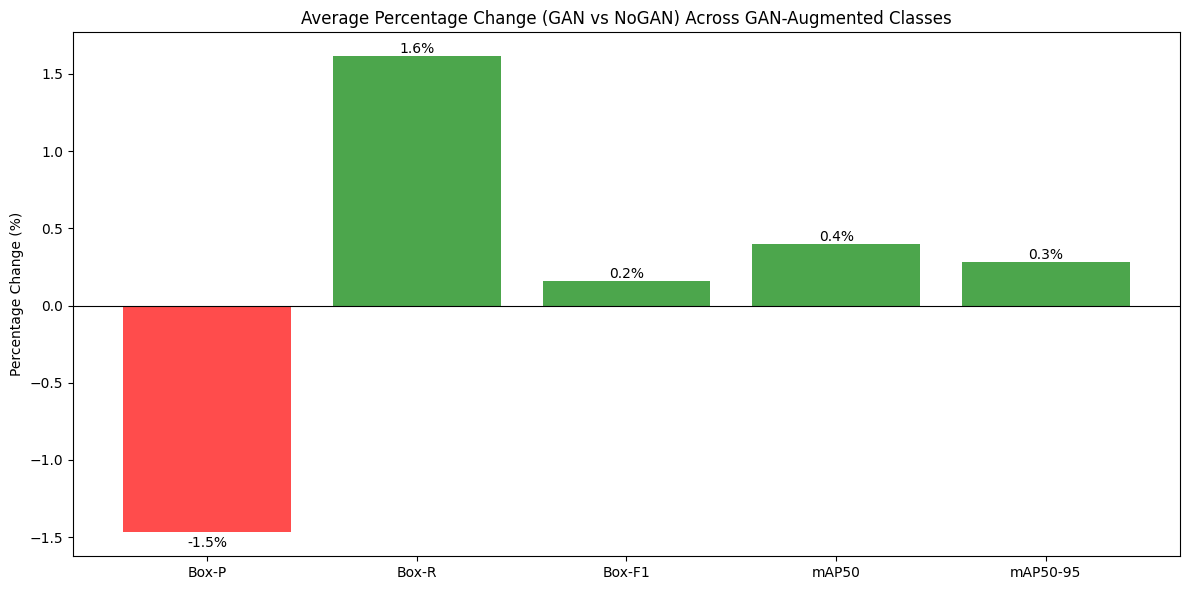

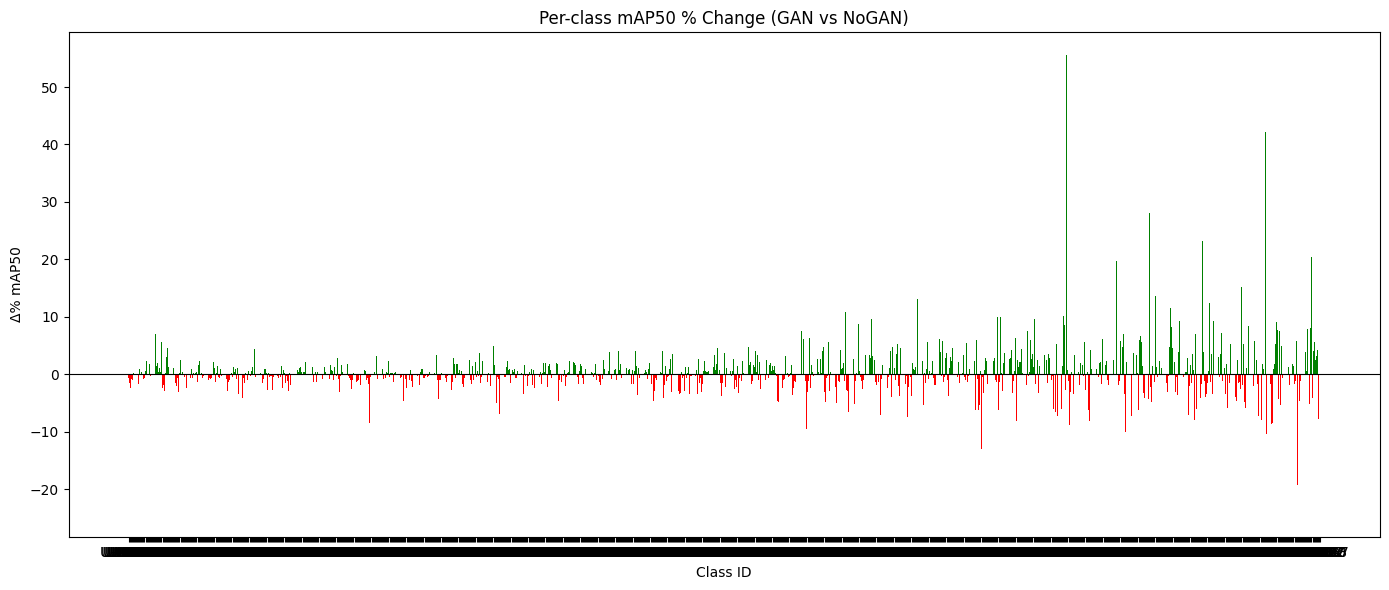


🔼 Top 10 Classes Improved by GAN (mAP50 %):
       Class  mAP50_Delta%
884   U+4E0E     55.526263
1072  U+5F0F     42.217324
962   U+89B3     28.094988
1012  U+5800     23.201801
1115  U+90AA     20.481125
931   U+73CD     19.745198
1049  U+5F25     15.210034
968   U+751A     13.632257
744   U+7A7A     13.063081
1019  U+632F     12.470862

🔽 Top 10 Classes Hurt by GAN (mAP50 %):
       Class  mAP50_Delta%
72    U+30FB    -24.259878
1102  U+8FF0    -19.263317
1074  U+7518    -14.891295
804   U+70B9    -12.968306
1026  U+8AAD    -11.087592
1073  U+79FB    -10.426200
940   U+800C     -9.955431
639   U+30B7     -9.499989
1025  U+8FCE     -8.892748
887   U+7BB8     -8.884780


In [4]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt

# Paths
csv_gan = "prev_runs/10_11_V11-500capGridGAN960imgsz100epochs/per_class_results.csv"
csv_no_gan = "prev_runs/26-09_V11-500capNoGAN960imgsz100epochs/per_class_results.csv"
selected_folder = "../GAN/selected"   # your GAN-generated folder

# Load CSVs
df_gan = pd.read_csv(csv_gan)
df_no_gan = pd.read_csv(csv_no_gan)

# Merge on Class
df = pd.merge(df_gan, df_no_gan, on="Class", suffixes=("_GAN", "_NoGAN"))

# Get list of GAN-augmented classes
selected_classes = [c for c in os.listdir(selected_folder) if os.path.isdir(os.path.join(selected_folder, c))]

# Filter
df_filtered = df[df["Class"].isin(selected_classes)]

# Metrics to compare
metrics = ["Box-P", "Box-R", "Box-F1", "mAP50", "mAP50-95"]


# Compute averages
gan_avgs = [df_filtered[f"{m}_GAN"].mean() for m in metrics]
nogan_avgs = [df_filtered[f"{m}_NoGAN"].mean() for m in metrics]

# Compute percentage change
delta_percent = [(g - n) / n * 100 for g, n in zip(gan_avgs, nogan_avgs)]

# Plot percentage change
x = range(len(metrics))
plt.figure(figsize=(12,6))
bars = plt.bar(x, delta_percent, color=["green" if d > 0 else "red" for d in delta_percent], alpha=0.7)
plt.axhline(0, color="black", linewidth=0.8)
plt.xticks(x, metrics)
plt.ylabel("Percentage Change (%)")
plt.title("Average Percentage Change (GAN vs NoGAN) Across GAN-Augmented Classes")
plt.tight_layout()

# Label bars with values
for i, d in enumerate(delta_percent):
    plt.text(i, d + (0 if d >= 0 else -0.02), f"{d:.1f}%", ha="center", va="bottom" if d >= 0 else "top")

plt.show()

#### Another another plot style

# Compute deltas (% change)
for metric in metrics:
    df[f"{metric}_Delta%"] = ((df[f"{metric}_GAN"] - df[f"{metric}_NoGAN"]) / df[f"{metric}_NoGAN"]) * 100

# ---- Plot per-class deltas for mAP50 ----
plt.figure(figsize=(14,6))
plt.bar(
    df["Class"], 
    df["mAP50_Delta%"], 
    color=["green" if x > 0 else "red" for x in df["mAP50_Delta%"]]
)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Per-class mAP50 % Change (GAN vs NoGAN)")
plt.xlabel("Class ID")
plt.ylabel("Δ% mAP50")
plt.tight_layout()
plt.show()

# ---- Print top improvements and declines ----
print("\n🔼 Top 10 Classes Improved by GAN (mAP50 %):")
print(df.sort_values("mAP50_Delta%", ascending=False)[["Class", "mAP50_Delta%"]].head(10))

print("\n🔽 Top 10 Classes Hurt by GAN (mAP50 %):")
print(df.sort_values("mAP50_Delta%", ascending=True)[["Class", "mAP50_Delta%"]].head(10))